# Load Data

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import special
from inspect import signature
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as md
from matplotlib.ticker import MultipleLocator

from scipy.integrate import quad

In [2]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams["axes.axisbelow"] = False

matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

In [3]:
!ls /home/alex/PhD/Gator/Data/PMTs_long_holders*/

/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/:
PMTs_long_holders_2units_bkgd_20241107_0_000.SPE
PMTs_long_holders_2units_bkgd_20241107_0_001.SPE
PMTs_long_holders_2units_bkgd_20241107_0_002.SPE
PMTs_long_holders_2units_bkgd_20241107_0_003.SPE
PMTs_long_holders_2units_bkgd_20241107_0_004.SPE
PMTs_long_holders_2units_bkgd_20241107_0_005.SPE
PMTs_long_holders_2units_bkgd_20241107_0_006.SPE
PMTs_long_holders_2units_bkgd_20241107_0_007.SPE
PMTs_long_holders_2units_bkgd_20241107_0_008.SPE
PMTs_long_holders_2units_bkgd_20241107_0_009.SPE
PMTs_long_holders_2units_bkgd_20241107_1_000.SPE
PMTs_long_holders_2units_bkgd_20241107_1_001.SPE
PMTs_long_holders_2units_bkgd_20241107_2_000.SPE
PMTs_long_holders_2units_bkgd_20241107_2_001.SPE
PMTs_long_holders_2units_bkgd_20241107_2_002.SPE
PMTs_long_holders_2units_bkgd_20241107_2_003.SPE
PMTs_long_holders_2units_bkgd_20241107_3_000.SPE
PMTs_long_holders_2units_bkgd_20241107_3_001.SPE
PMTs_long_holders_2units_bkgd_20241107_3_002.SPE
PMTs_long_h

In [4]:
data_cleaning_path = './'
data_cleaning_filename = 'dirty_runs_filename_list.txt'
with open(data_cleaning_path+data_cleaning_filename) as file:
    files_to_remove = [line.rstrip() for line in file]
files_to_remove

['PMTs_long_holders_2units_bkgd_20241107_0_000.SPE',
 'PMTs_long_holders_2units_bkgd_20241107_4_012.SPE',
 'PMTs_long_holders_2units_bkgd_20241107_4_053.SPE',
 'PMTs_long_holders_2units_bkgd_20241107_4_096.SPE',
 'PMTs_long_holders_2units_bkgd_20241107_4_138.SPE',
 'PMTs_long_holders_3units_bkgd_20241210_0_020.SPE',
 'PMTs_long_holders_3units_bkgd_20241210_0_060.SPE',
 'PMTs_long_holders_3units_bkgd_20241210_0_096.SPE',
 'PMTs_long_holders_3units_bkgd_20241210_0_139.SPE']

In [5]:
path_sample = '/home/alex/PhD/Gator/Data/PMTs_long_holders_3units_bkgd/'
files_list_sample = np.array(glob.glob(path_sample+'PMTs_long_holders_3units_bkgd*'))
path_background = '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/'
files_list_background = np.array(glob.glob(path_background+'PMTs_long_holders_2units_bkgd*'))

sample_name = '3 Holders'
background_name = '2 Holders'
save_name = 'Comparison_2_3_Holders'

units = 1 ## we have 8 PMTs

## Remove outliers

files_list_sample = np.sort(files_list_sample)
#print(len(files_list_sample))
files_list_sample = np.array([el for el in files_list_sample if el.split('/')[-1] not in files_to_remove])
#print(len(files_list_sample))

files_list_background = np.sort(files_list_background)
#print(len(files_list_background))
files_list_background = np.array([el for el in files_list_background if el.split('/')[-1] not in files_to_remove])
#print(len(files_list_background))

In [6]:
def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

def load_files(files_list):
    for i_file, file in tqdm(enumerate(files_list)):
        if i_file == 0:
            df_combined, live_time_combined = load_file(file)[0:2]
        else:
            df_temp, live_time_temp = load_file(file)[0:2]
            if len(df_combined) == len(df_temp):
                df_combined.counts = df_combined.counts + df_temp.counts
                live_time_combined = live_time_combined + live_time_temp
            else:
                raise ValueError("file "+str(file)+" has different number of channels compared to previous file")
                
    print('total live time = '+str(live_time_combined)+' s = '+str(round(live_time_combined/(24*60*60),2))+' d')
    return df_combined, live_time_combined

In [7]:
df_sample, total_live_time_sample = load_files(files_list_sample)
df_background, total_live_time_background = load_files(files_list_background)

164it [00:01, 102.94it/s]


total live time = 2357907 s = 27.29 d


181it [00:01, 104.20it/s]

total live time = 2606399 s = 30.17 d


In [8]:
print(len(files_list_sample)/(24/4))

27.333333333333332


In [9]:
## Uncertainty counts

df_sample['counts_err'] = np.sqrt(df_sample['counts'])
df_background['counts_err'] = np.sqrt(df_background['counts'])

In [10]:
## Energy Calibration
## TODO: UPDATE WITH LATEST ENERGY CALIBRATION!!!

#al_CE_a = 0.16389984701772356 # 2023.11
#al_CE_b = 0.46454797148251575 # 2023.11
cal_CE_a = 0.16395071397817926 # 2024.07
cal_CE_b = 0.6649302765158444 # 2024.07
cal_CE = (cal_CE_a, cal_CE_b)
cal_EC_a = 1/cal_CE_a
cal_EC_b = -cal_CE_b/cal_CE_a
cal_EC = (cal_EC_a, cal_EC_b)

def func_e_to_adc(x = np.array([100, 2700]), a = cal_EC_a, b = cal_EC_b):
    res = a*x+b
    return res
def func_adc_to_e(x = np.array([0, 16383]), a = cal_CE_a, b = cal_CE_b):
    res = a*x+b
    return res

df_sample['energy'] = func_adc_to_e(df_sample.channel) ## in keV
df_background['energy'] = func_adc_to_e(df_background.channel) ## in keV

channel_width_e_sample = (func_adc_to_e(df_sample.channel+0.5)-func_adc_to_e(df_sample.channel-0.5))
channel_width_e_background = (func_adc_to_e(df_background.channel+0.5)-func_adc_to_e(df_background.channel-0.5))

In [11]:
## Normalized Rate

mass = 1 ## not used here

total_live_time_sample_days = total_live_time_sample/(24*60*60)
df_sample['rate'] = (df_sample.counts) / (mass * total_live_time_sample_days * channel_width_e_sample) ## in events/day/keV
df_sample['rate_err'] = (df_sample.counts_err) / (mass * total_live_time_sample_days * channel_width_e_sample) ## in events/day/keV

total_live_time_background_days = total_live_time_background/(24*60*60)
df_background['rate'] = (df_background.counts) / (mass * total_live_time_background_days * channel_width_e_background) ## in events/day/keV
df_background['rate_err'] = (df_background.counts_err) / (mass * total_live_time_background_days * channel_width_e_background) ## in events/day/keV

In [12]:
def rebin_df(df_in = df_sample, size = 16):
    df = df_in.copy()
    
    if len(df)/size - int(len(df)/size) != 0:
        print("Warning: len(df)/size isn't an integer, better use multiples of 2 for size.")

    energy_list = np.array(df['energy'])
    energy_list = energy_list.reshape(int(len(energy_list)/size), size)
    energy_list = np.mean(energy_list, axis = 1)

    rate_list = np.array(df['rate'])
    rate_list = rate_list.reshape(int(len(rate_list)/size), size)
    rate_list = np.mean(rate_list, axis = 1)

    counts_list = np.array(df['counts'])
    counts_list = counts_list.reshape(int(len(counts_list)/size), size)
    counts_list = np.sum(counts_list, axis = 1)
    
    counts_err_list = np.sqrt(counts_list)
    rate_err_list = rate_list * counts_err_list/np.maximum(counts_list,1)
    
    df_out = pd.DataFrame(data={'energy': energy_list, 
                                'counts': counts_list, 'counts_err': counts_err_list, 
                                'rate': rate_list, 'rate_err': rate_err_list})
    
    return df_out

In [13]:
df_sample_rebin = rebin_df(df_in = df_sample, size = 16)
df_background_rebin = rebin_df(df_in = df_background, size = 16)

In [14]:
df_Th234 = pd.DataFrame(data = {'isotope': ['Th-234']*1, 
                               'energy': [92.6]})
df_U235 = pd.DataFrame(data = {'isotope': ['U-235']*1, 
                               'energy': [185.72]})
df_Pb212 = pd.DataFrame(data = {'isotope': ['Pb-212']*1, 
                               'energy': [238.632]})
df_Pb214 = pd.DataFrame(data = {'isotope': ['Pb-214']*2, 
                               'energy': [295.224, 351.932]})
df_Ac228 = pd.DataFrame(data = {'isotope': ['Ac-228']*3, 
                               'energy': [338.32, 911.196, 968.96]})
df_Ac228_sel = pd.DataFrame(data = {'isotope': ['Ac-228']*2, 
                               'energy': [911.196, 968.96]})

df_Ac228_extra = pd.DataFrame(data = {'isotope': ['Ac-228']*5, 
                               'energy': [463.004, 794.947, 1588.19, 209.253, 270.245]})

df_Tl208 = pd.DataFrame(data = {'isotope': ['Tl-208']*2, 
                               'energy': [583.187, 2614.51]})
df_Tl208_extra = pd.DataFrame(data = {'isotope': ['Tl-208']*1, 
                               'energy': [860.564]})
df_Bi214 = pd.DataFrame(data = {'isotope': ['Bi-214']*3, 
                               'energy': [609.312, 1120.29, 1764.49]})
df_Bi214_extra_1 = pd.DataFrame(data = {'isotope': ['Bi-214']*2, 
                               'energy': [1238.110, 2204.21]})
df_Bi214_extra = pd.DataFrame(data = {'isotope': ['Bi-214']*12, 
                               'energy': [1238.110, 2204.21, 768.356, 1377.669, 
                                          934.061, 1729.595, 1407.98, 1509.228, 
                                          1847.420, 2447.86, 1280.96, 2118.55]})
df_Bi214_sel = pd.DataFrame(data = {'isotope': ['Bi-214']*2, 
                               'energy': [609.312, 1764.49]})
df_Cs137 = pd.DataFrame(data = {'isotope': ['Cs-137']*1, 
                               'energy': [661.657]})
df_Mn54 = pd.DataFrame(data = {'isotope': ['Mn-54']*1, 
                               'energy': [834.838]})
df_Sc46 = pd.DataFrame(data = {'isotope': ['Sc-46']*2, 
                               'energy': [889.271, 1120.54]})
df_Sc46_sel = pd.DataFrame(data = {'isotope': ['Sc-46']*1, 
                               'energy': [889.271]})
df_Co60 = pd.DataFrame(data = {'isotope': ['Co-60']*2, 
                               'energy': [1173.23, 1332.49]})
df_Co58 = pd.DataFrame(data = {'isotope': ['Co-58']*1, 
                               'energy': [810.775]})
df_K40 = pd.DataFrame(data = {'isotope': ['K-40']*1, 
                               'energy': [1460.88]})
df_ee =  pd.DataFrame(data = {'isotope': ['e$^+$e$^-$']*1, 
                               'energy': [510.998950]})
df_Pa234m = pd.DataFrame(data = {'isotope': ['Pa-234m']*1, 
                               'energy': [1001.03]})

In [15]:
lines_list = [df_U235, df_Pb212, df_Pb214, df_Tl208, df_Bi214, df_Bi214_extra_1, df_K40, df_Ac228_sel, df_ee, df_Co60, df_Cs137, df_Co58, df_Mn54]#, df_Pa234m, df_Bi214_extra, df_Tl208_extra, df_Ac228_extra]

for i, el in enumerate(lines_list):
    if i>0:
        df_lines = df_lines.append(el, ignore_index=True)
    else:
        df_lines = el
        
df_lines

/tmp/ipykernel_24975/1480720442.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lines = df_lines.append(el, ignore_index=True)


,isotope,energy
0,U-235,185.72000
1,Pb-212,238.63200
2,Pb-214,295.22400
3,Pb-214,351.93200
4,Tl-208,583.18700
5,Tl-208,2614.51000
6,Bi-214,609.31200
7,Bi-214,1120.29000
8,Bi-214,1764.49000
9,Bi-214,1238.11000


In [16]:
diff = df_sample_rebin.rate - df_background_rebin.rate
diff_err = np.sqrt(df_sample_rebin.rate_err**2 + df_background_rebin.rate_err**2)

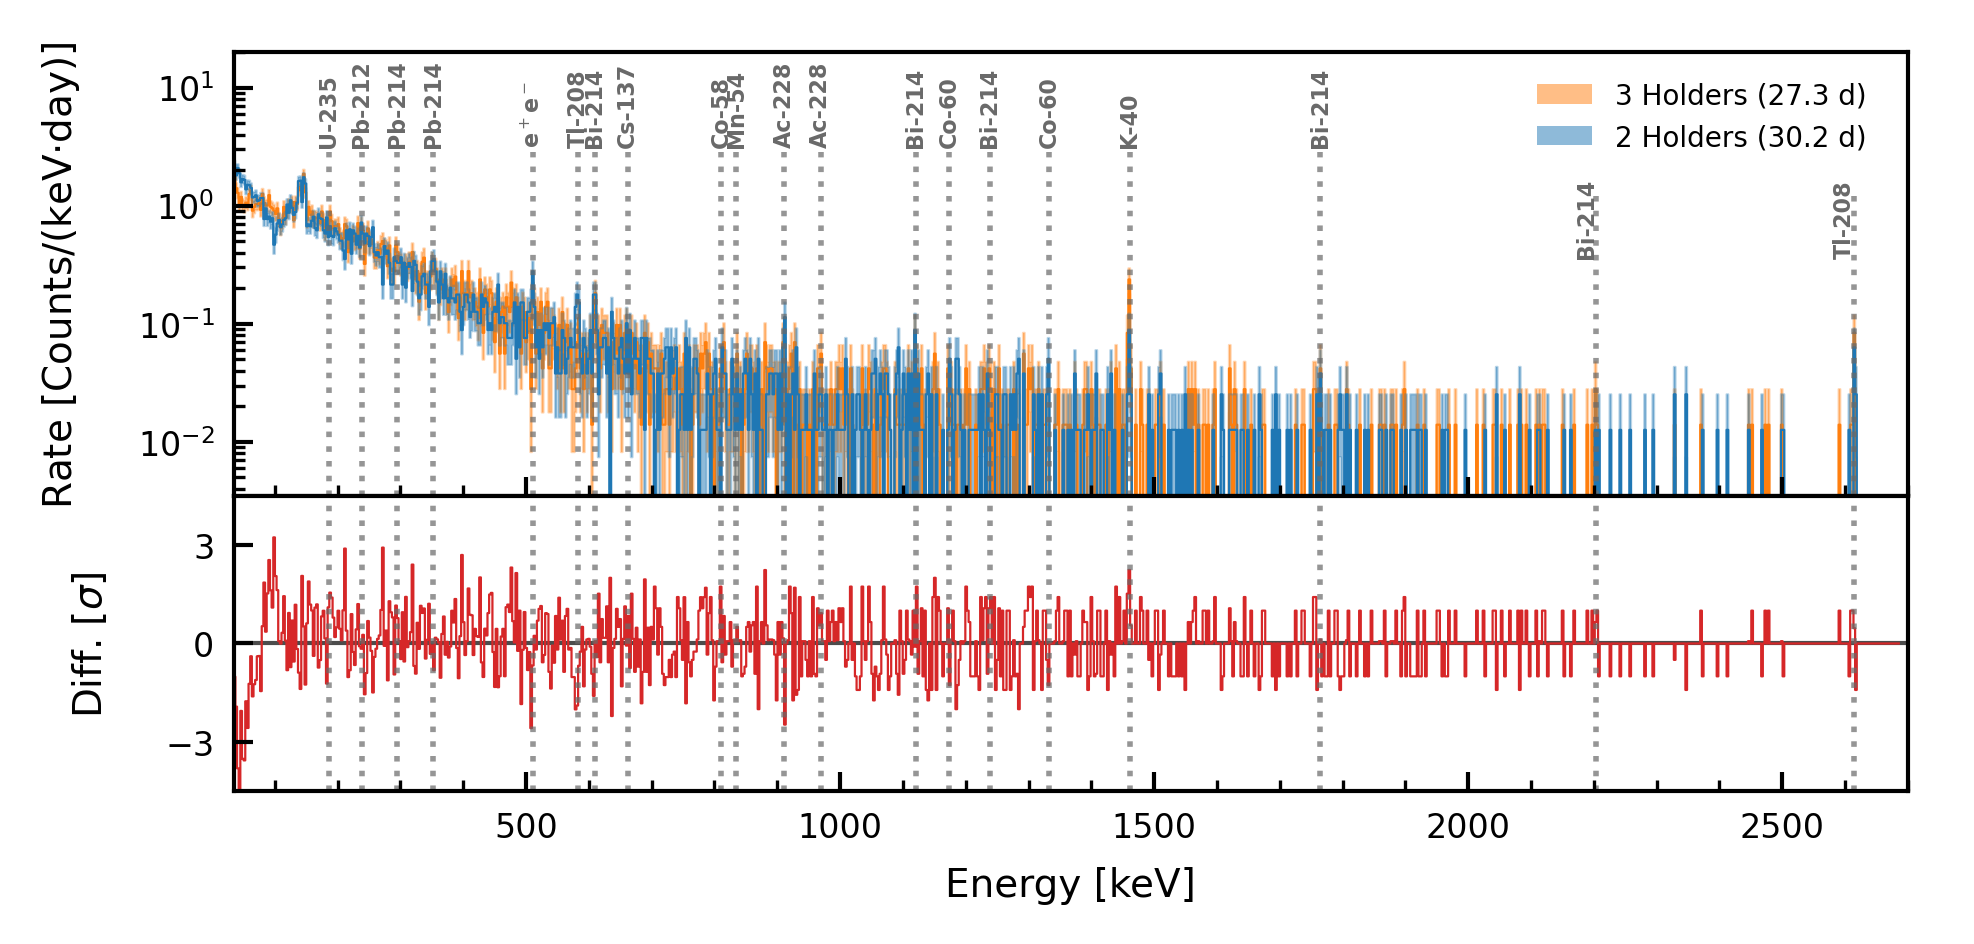

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [1.5, 1]}, 
                               figsize=(27/5,1.5*8/5), dpi = 400, 
                               sharex = True)

ax1.step(df_sample_rebin.energy, df_sample_rebin.rate, 
         where='mid', linewidth = 0.4, color = 'C1')
ax1.step(df_sample_rebin.energy, df_sample_rebin.rate-df_sample_rebin.rate_err, 
         where='mid', linewidth = 0.4, color = 'C1', alpha = 0.3)
ax1.step(df_sample_rebin.energy, df_sample_rebin.rate+df_sample_rebin.rate_err, 
         where='mid', linewidth = 0.4, color = 'C1', alpha = 0.3)
#fill_mask_low = np.ones_like(df_sample_rebin.energy) 
#fill_mask_low[(df_background_rebin.rate > df_sample_rebin.rate)] = np.nan
#line1 = ax1.fill_between(df_sample_rebin.energy, fill_mask_low*df_background_rebin.rate, fill_mask_low*df_sample_rebin.rate, 
#                 step="mid", color = 'C1', alpha=0.5, linewidth = 0,
#                 label = sample_name+' ('+str(round(total_live_time_sample_days,1))+' d)')
line1 = ax1.fill_between(df_sample_rebin.energy, 
                         df_sample_rebin.rate-df_sample_rebin.rate_err, 
                         df_sample_rebin.rate+df_sample_rebin.rate_err, 
                 step="mid", color = 'C1', alpha=0.5, linewidth = 0, 
                 label = sample_name+' ('+str(round(total_live_time_sample_days,1))+' d)')

ax1.step(df_background_rebin.energy, df_background_rebin.rate, 
         where='mid', linewidth = 0.4, color = 'C0')
ax1.step(df_background_rebin.energy, df_background_rebin.rate-df_background_rebin.rate_err, 
         where='mid', linewidth = 0.4, color = 'C0', alpha = 0.3)
ax1.step(df_background_rebin.energy, df_background_rebin.rate+df_background_rebin.rate_err, 
         where='mid', linewidth = 0.4, color = 'C0', alpha = 0.3)
line2 = ax1.fill_between(df_background_rebin.energy, 
                         df_background_rebin.rate-df_background_rebin.rate_err, 
                         df_background_rebin.rate+df_background_rebin.rate_err, 
                 step="mid", color = 'C0', alpha=0.5, linewidth = 0, 
                 label = background_name+' ('+str(round(total_live_time_background_days,1))+' d)')

for lbl, en in np.array([df_lines.isotope, df_lines.energy]).T:
    if en < 2000:
        x = (en-35)/(2700-35)
        ymax_line = 0.8-0.025#-0.06
        ymax = ymax_line
    else:
        x = (en-35)/(2700-35)-0.006
        ymax_line = 0.7-0.025
        ymax = ymax_line-0.15
    ax1.axvline(en, color = 'dimgray', linestyle = 'dotted', linewidth = 1, alpha = 0.7, ymax = ymax_line)
    
    ax1.text(x = x, y = ymax+0.01, s = lbl, c = 'dimgray',
             transform=ax1.transAxes, rotation=90, fontsize = 4.0, fontweight = 'semibold',
             horizontalalignment='center', verticalalignment='bottom', multialignment='center')

ax1.tick_params(axis='x', labelbottom=False)

ax1.xaxis.set_major_locator(MultipleLocator(500))
ax1.xaxis.set_minor_locator(MultipleLocator(100))

ax1.set_yscale('log')
ax1.set_xlim(35,2700)
ax1.set_ylim(3.5e-3, 2e1)
#ax1.set_xlabel('Energy [keV]')

legend = ax1.legend(handles = [line1, line2], 
                    #loc=1, bbox_to_anchor=(0.99,0.99), 
                    loc=1, bbox_to_anchor=(0.99,0.99), 
                    frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0)

########

ax2.axhline(y=0, color = 'k', linestyle = '-', linewidth = 0.75, alpha = 0.7)
normdiff = diff/diff_err
normdiff = np.nan_to_num(normdiff) # replace nan with 0
ax2.step(df_sample_rebin.energy, normdiff, 
         where='mid', linewidth = 0.4, color = 'C3',
         label = 'Difference R11410\nPMTs - Background')

ax2.set_yscale('linear')
ax2.set_xlim(35,2700)
ax2.set_ylim(-4.5, 4.5)

ax2.xaxis.set_major_locator(MultipleLocator(500))
ax2.xaxis.set_minor_locator(MultipleLocator(100))
ax2.yaxis.set_major_locator(MultipleLocator(3))

ax2.set_xlabel('Energy [keV]')

for lbl, en in np.array([df_lines.isotope, df_lines.energy]).T:
    x = (en-35)/(2700-35)
    ax2.axvline(en, color = 'dimgray', linestyle = 'dotted', linewidth = 1, alpha = 0.7)
    
#legend = ax2.legend(handles = [line3], 
#                    loc=2, bbox_to_anchor=(0.55,0.99), 
#                    frameon=True, shadow=False, edgecolor='black', fancybox=False)
#legend.get_frame().set_linewidth(0)

########

#ax1.set_ylabel('Rate [Counts/(keV$\cdot$day)]')
#fig.supylabel('Rate [Counts/(keV$\cdot$day)]')

#fig.tight_layout()

plt.subplots_adjust(hspace=.0)

fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both',                
                top = False, bottom = False, left = False, right = False)
ax1.set_ylabel('Rate [Counts/(keV$\cdot$day)]', labelpad = 10)
ax2.set_ylabel('Diff. [$\sigma$]', labelpad = 10)

plt.savefig('spectrum_'+save_name+'.png', transparent=False, bbox_inches='tight')
plt.savefig('spectrum_'+save_name+'.pdf', transparent=False, bbox_inches='tight')

plt.show()

# Check Lines

In [18]:
## TODO: REPLACE WITH LATEST CALIBRATION FUNCTION!!!
#p_resol = (0.1949545343471076, 0.0004042390399916367, 1.7629403715106498e-08) # very old values
p_resol = (0.1640793763268678, 0.00044153166853607486, 7.220690814845775e-28) # 2024-07

def resolFunc(E, a=p_resol[0], b=p_resol[1], c=p_resol[2]):
    relresol = E * np.sqrt(a/E**2 + b/E + c)
    return relresol

In [19]:
for lbl, en in np.array([df_lines.isotope, df_lines.energy]).T:
    print('spectrum_'+save_name+'_'+lbl+'_'+str(int(en)))

spectrum_Comparison_2_3_Holders_U-235_185
spectrum_Comparison_2_3_Holders_Pb-212_238
spectrum_Comparison_2_3_Holders_Pb-214_295
spectrum_Comparison_2_3_Holders_Pb-214_351
spectrum_Comparison_2_3_Holders_Tl-208_583
spectrum_Comparison_2_3_Holders_Tl-208_2614
spectrum_Comparison_2_3_Holders_Bi-214_609
spectrum_Comparison_2_3_Holders_Bi-214_1120
spectrum_Comparison_2_3_Holders_Bi-214_1764
spectrum_Comparison_2_3_Holders_Bi-214_1238
spectrum_Comparison_2_3_Holders_Bi-214_2204
spectrum_Comparison_2_3_Holders_K-40_1460
spectrum_Comparison_2_3_Holders_Ac-228_911
spectrum_Comparison_2_3_Holders_Ac-228_968
spectrum_Comparison_2_3_Holders_e$^+$e$^-$_510
spectrum_Comparison_2_3_Holders_Co-60_1173
spectrum_Comparison_2_3_Holders_Co-60_1332
spectrum_Comparison_2_3_Holders_Cs-137_661
spectrum_Comparison_2_3_Holders_Co-58_810
spectrum_Comparison_2_3_Holders_Mn-54_834


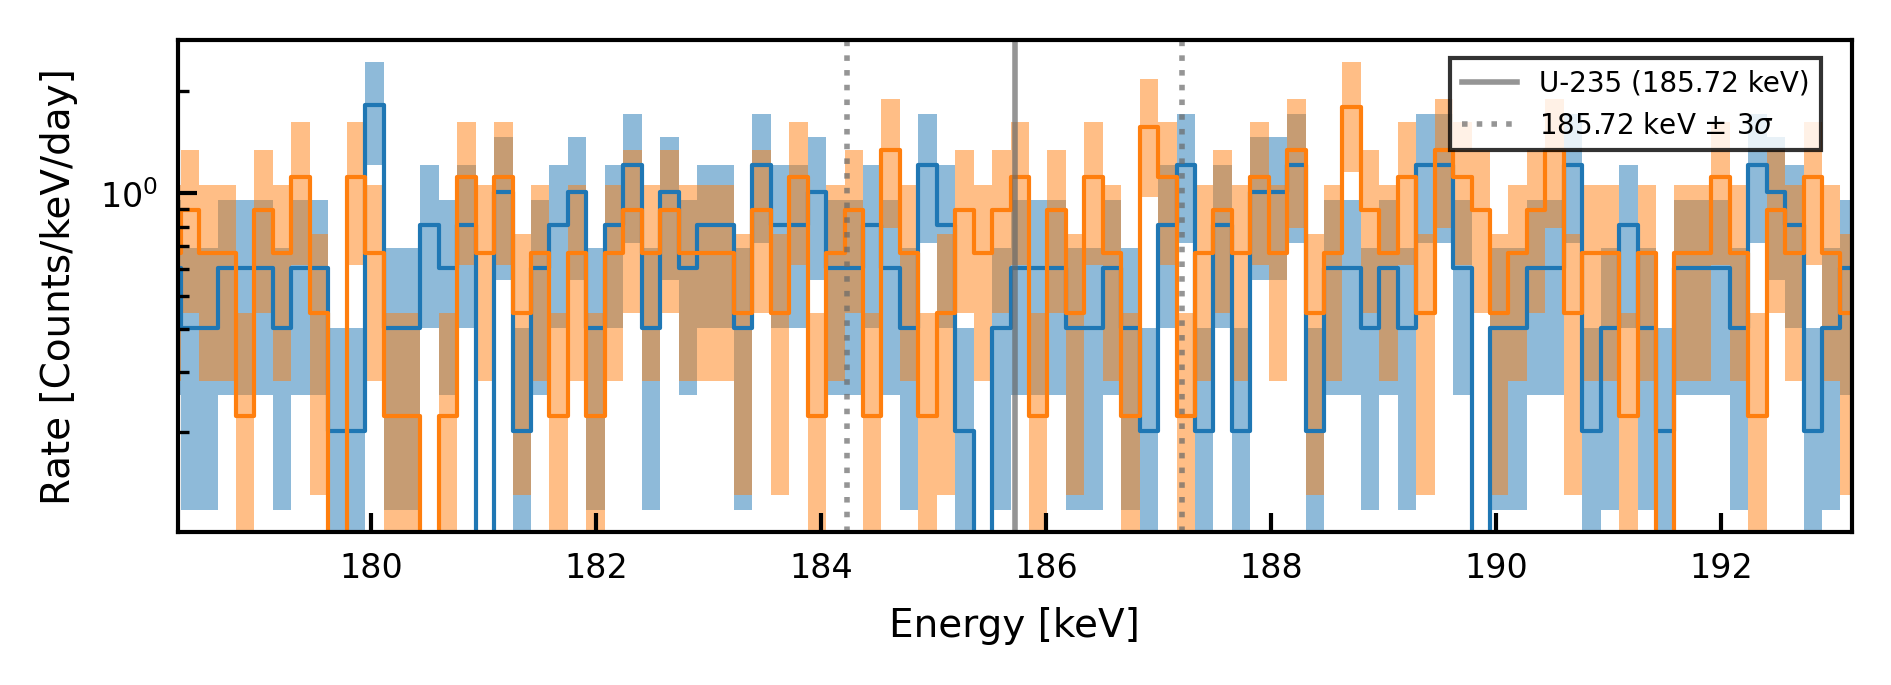

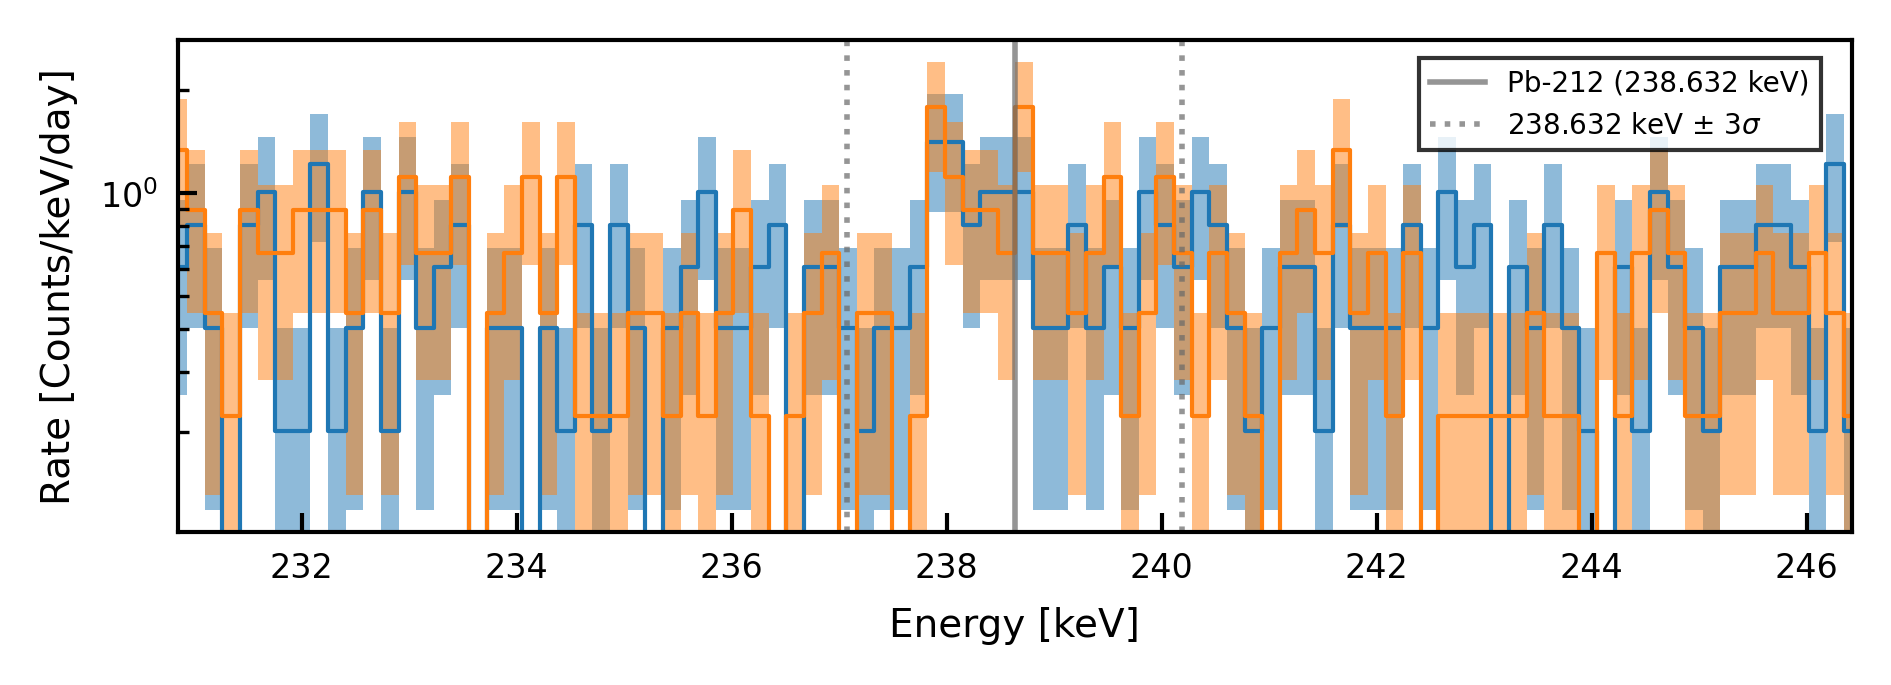

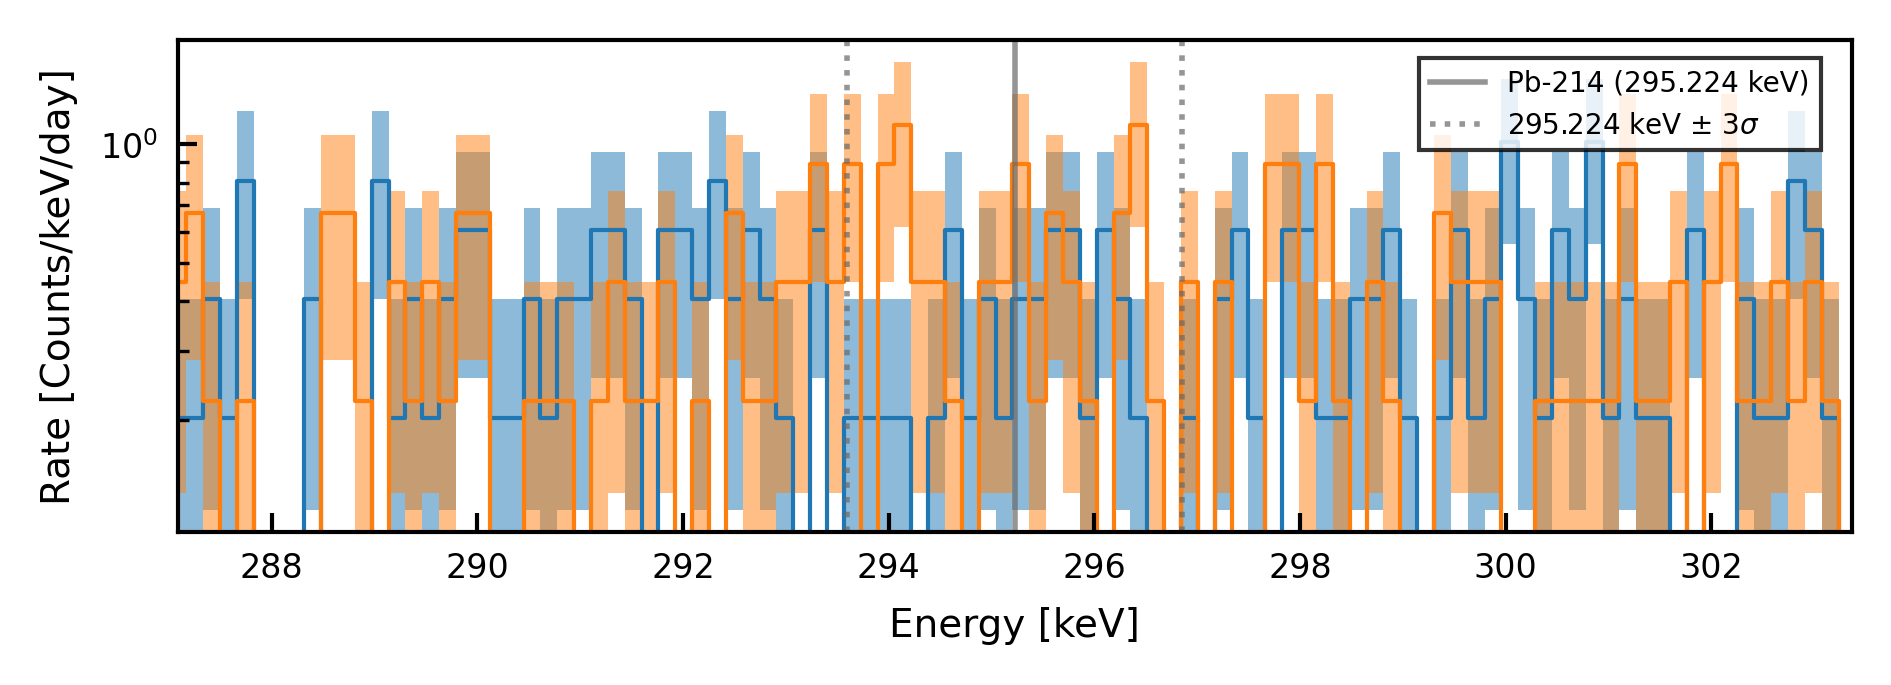

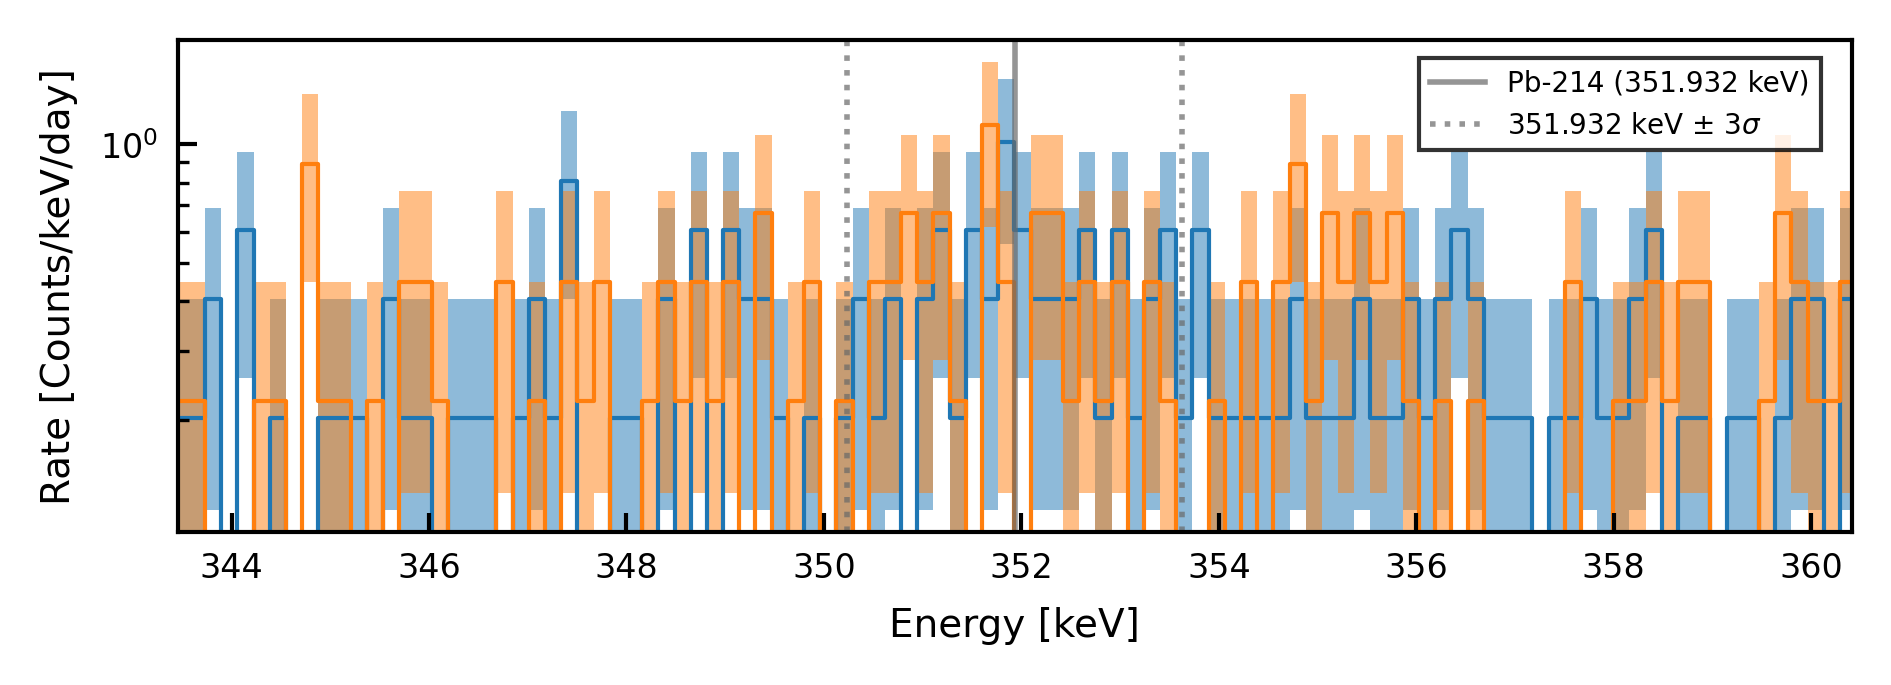

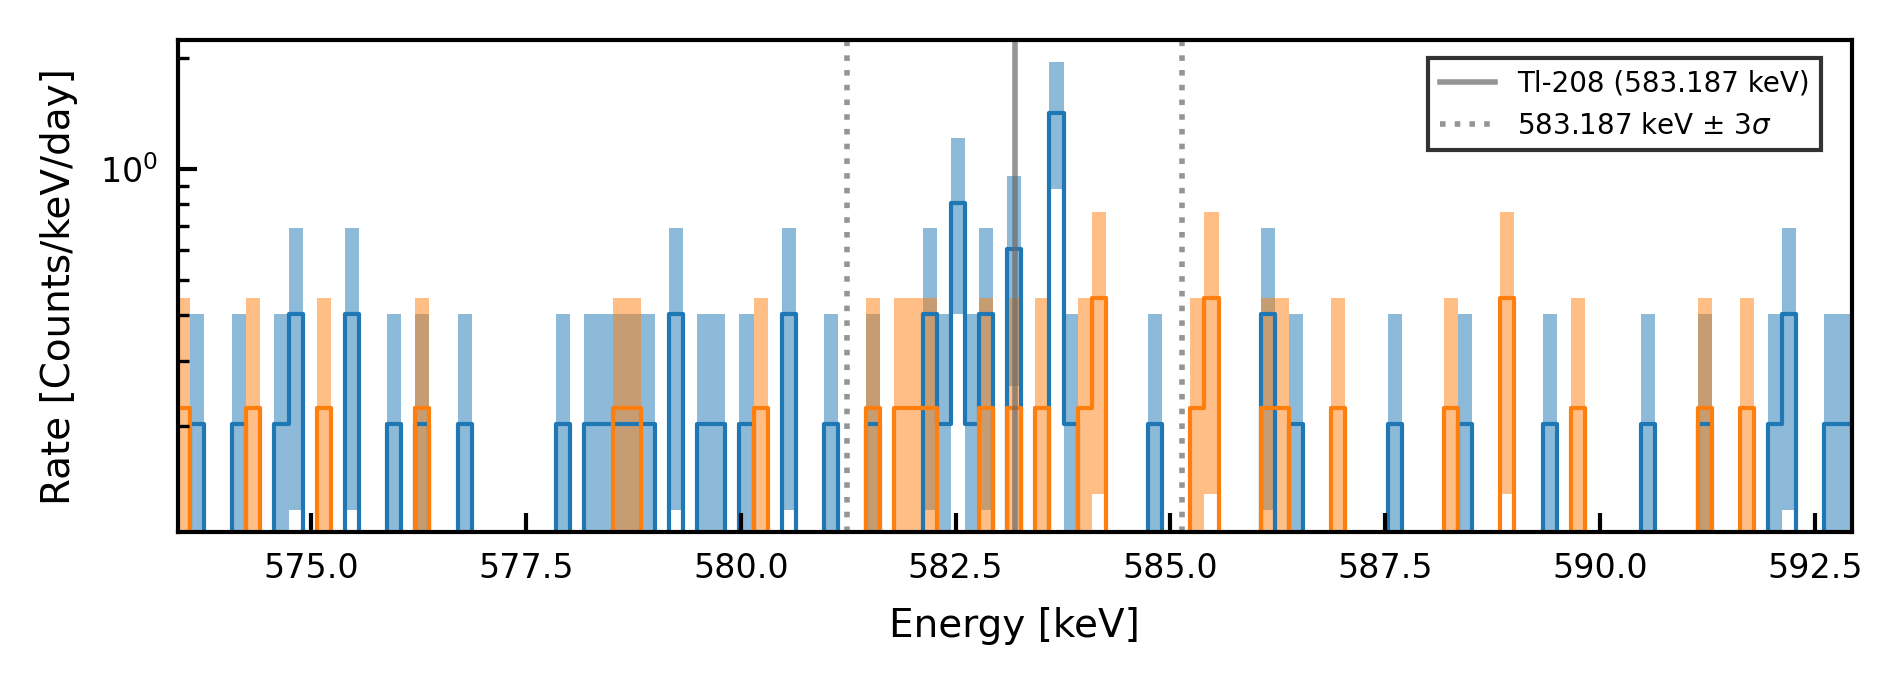

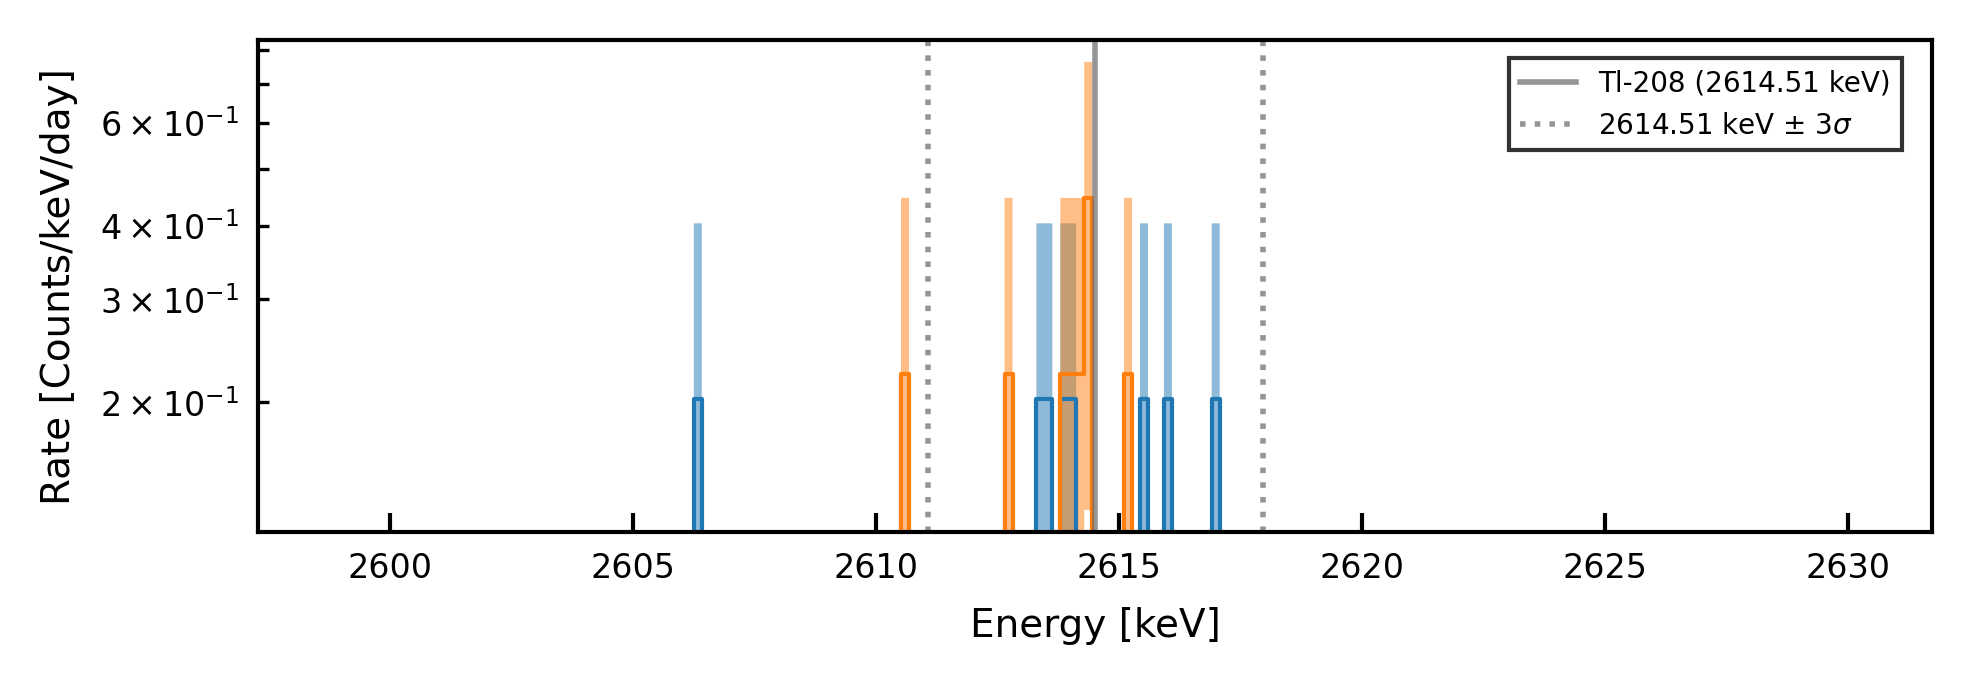

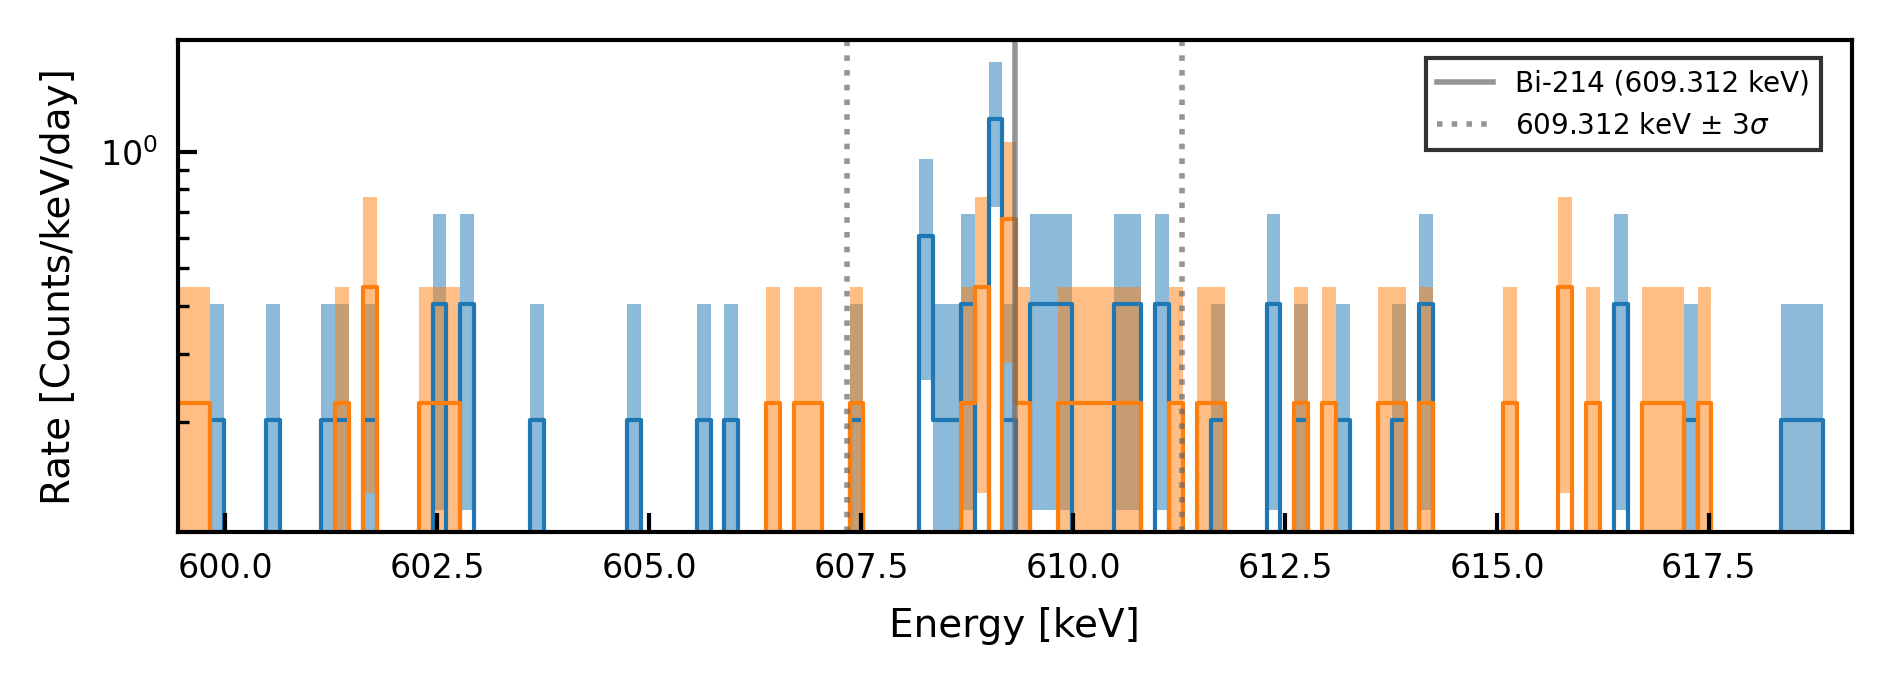

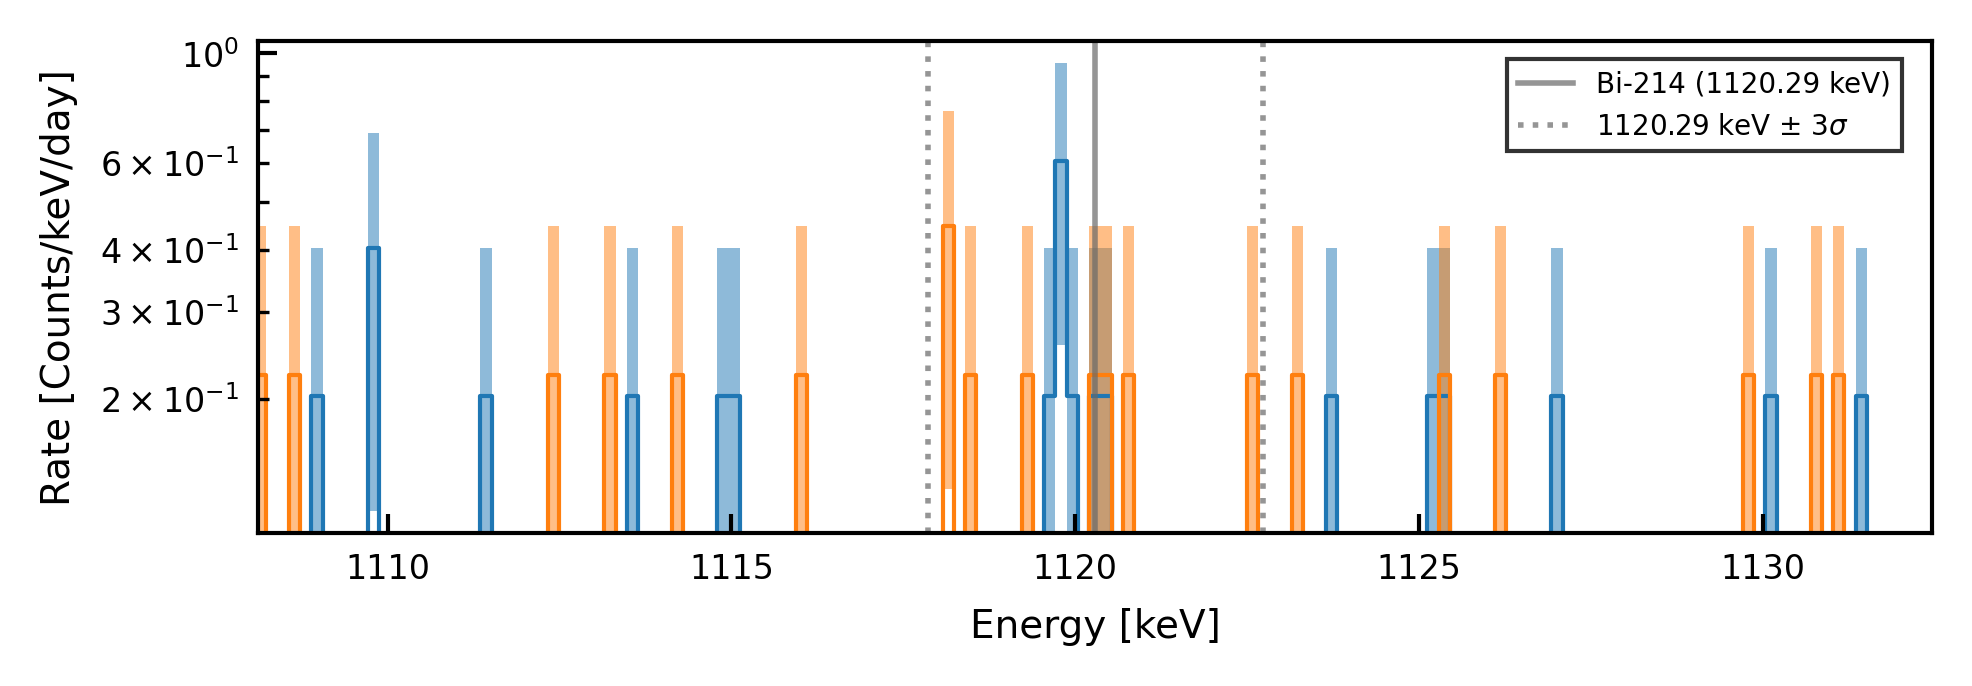

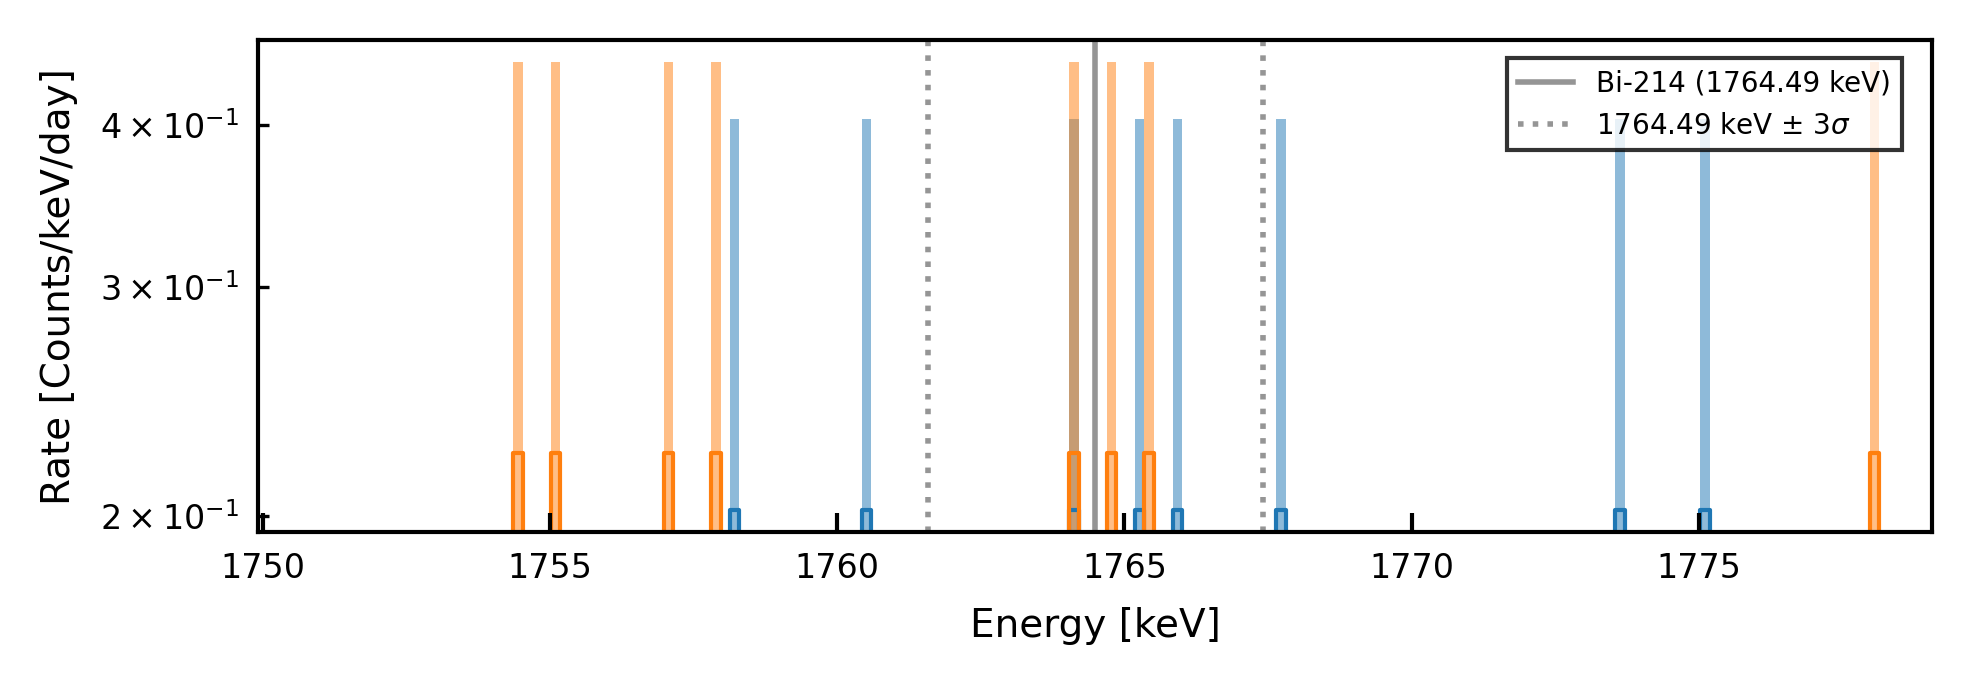

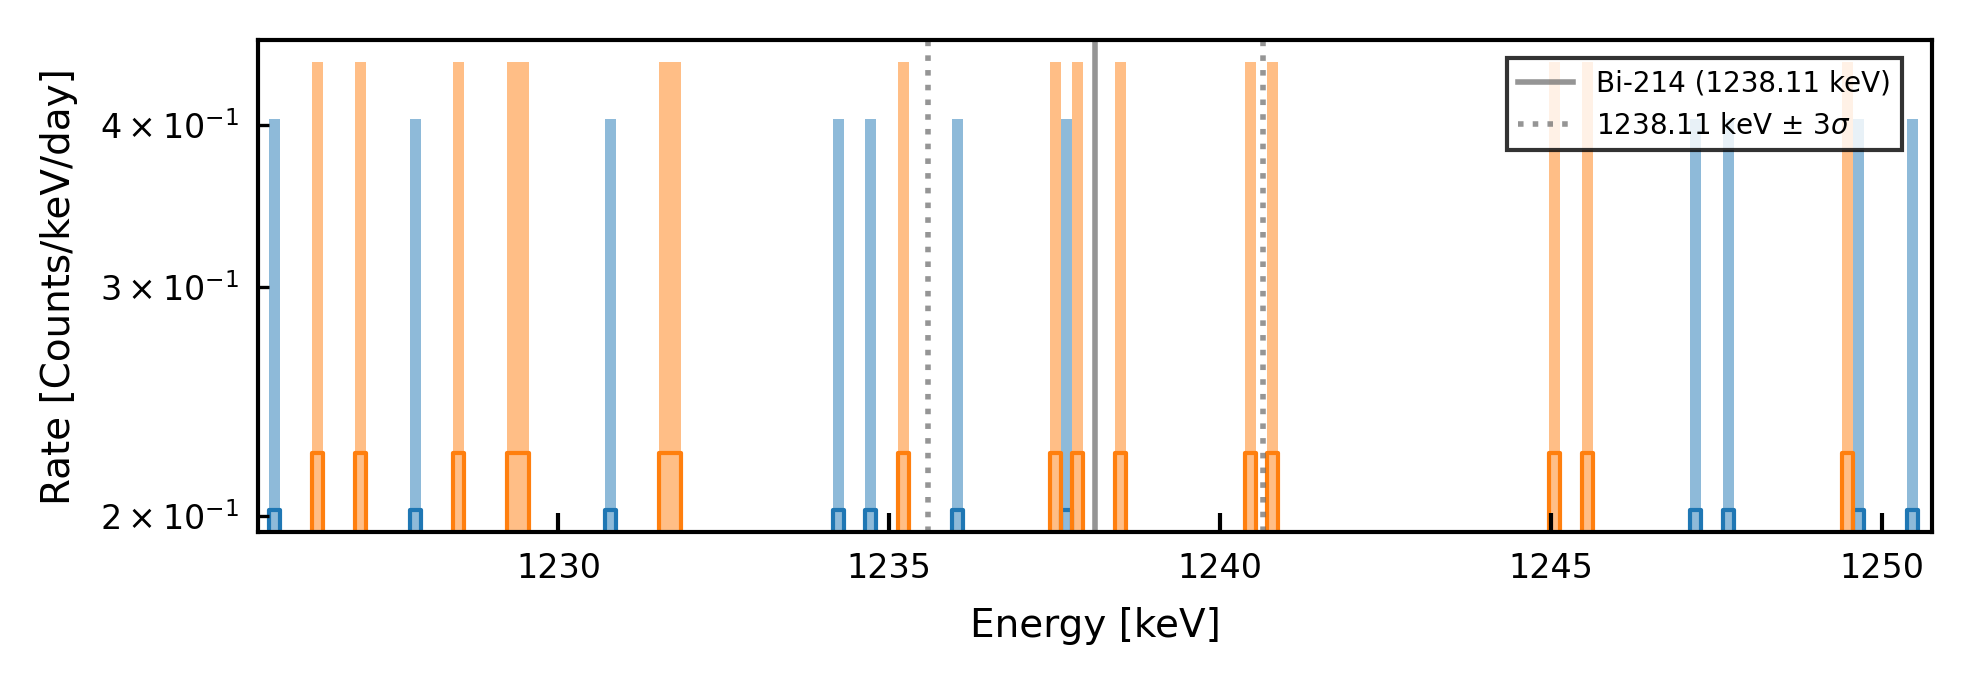

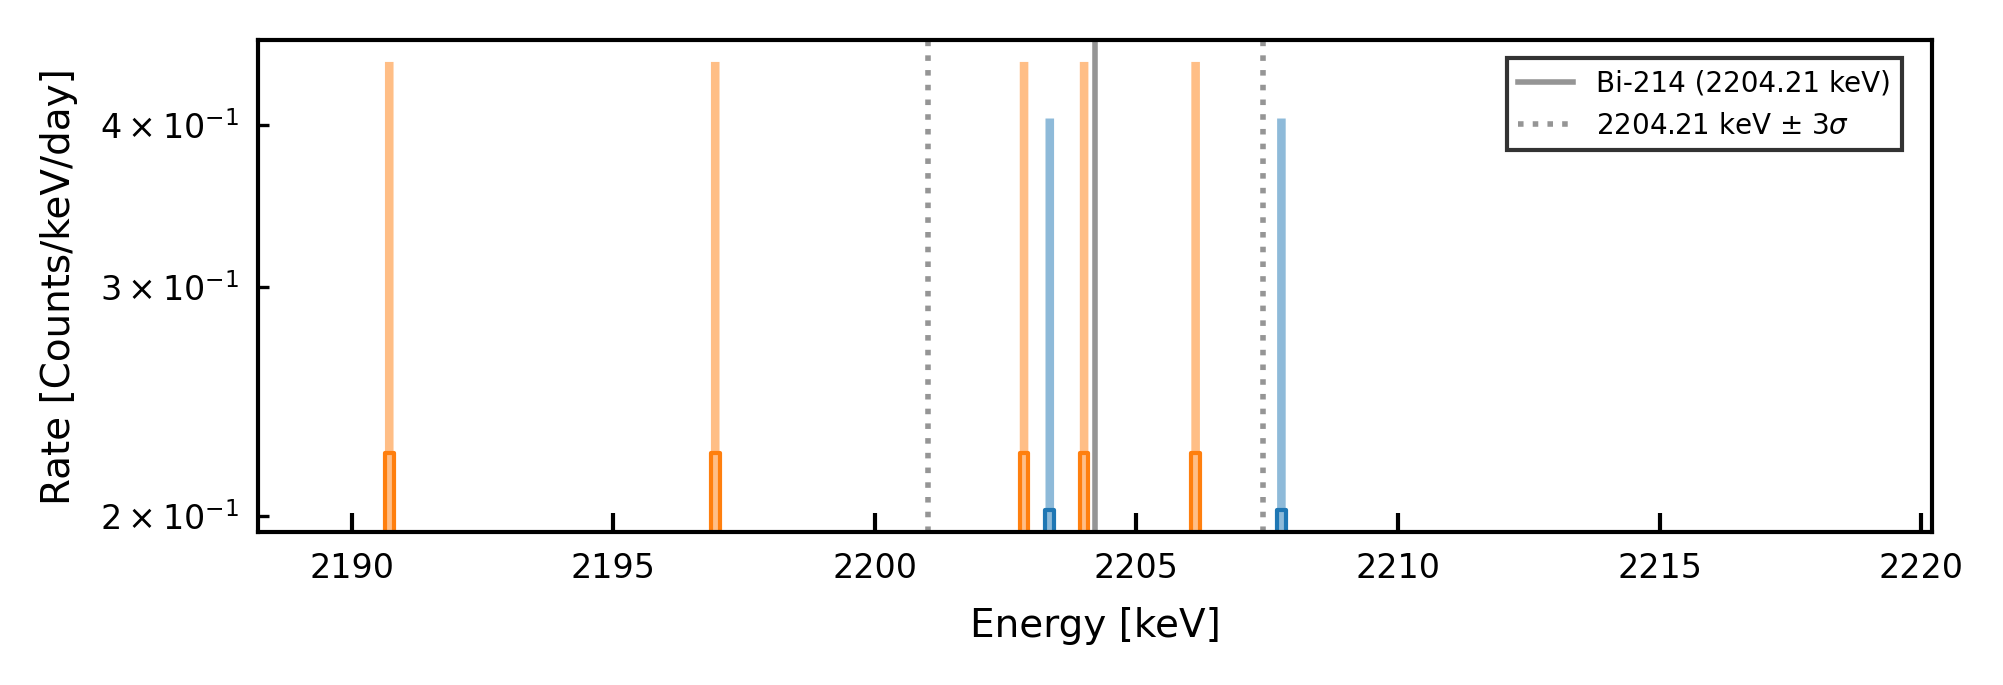

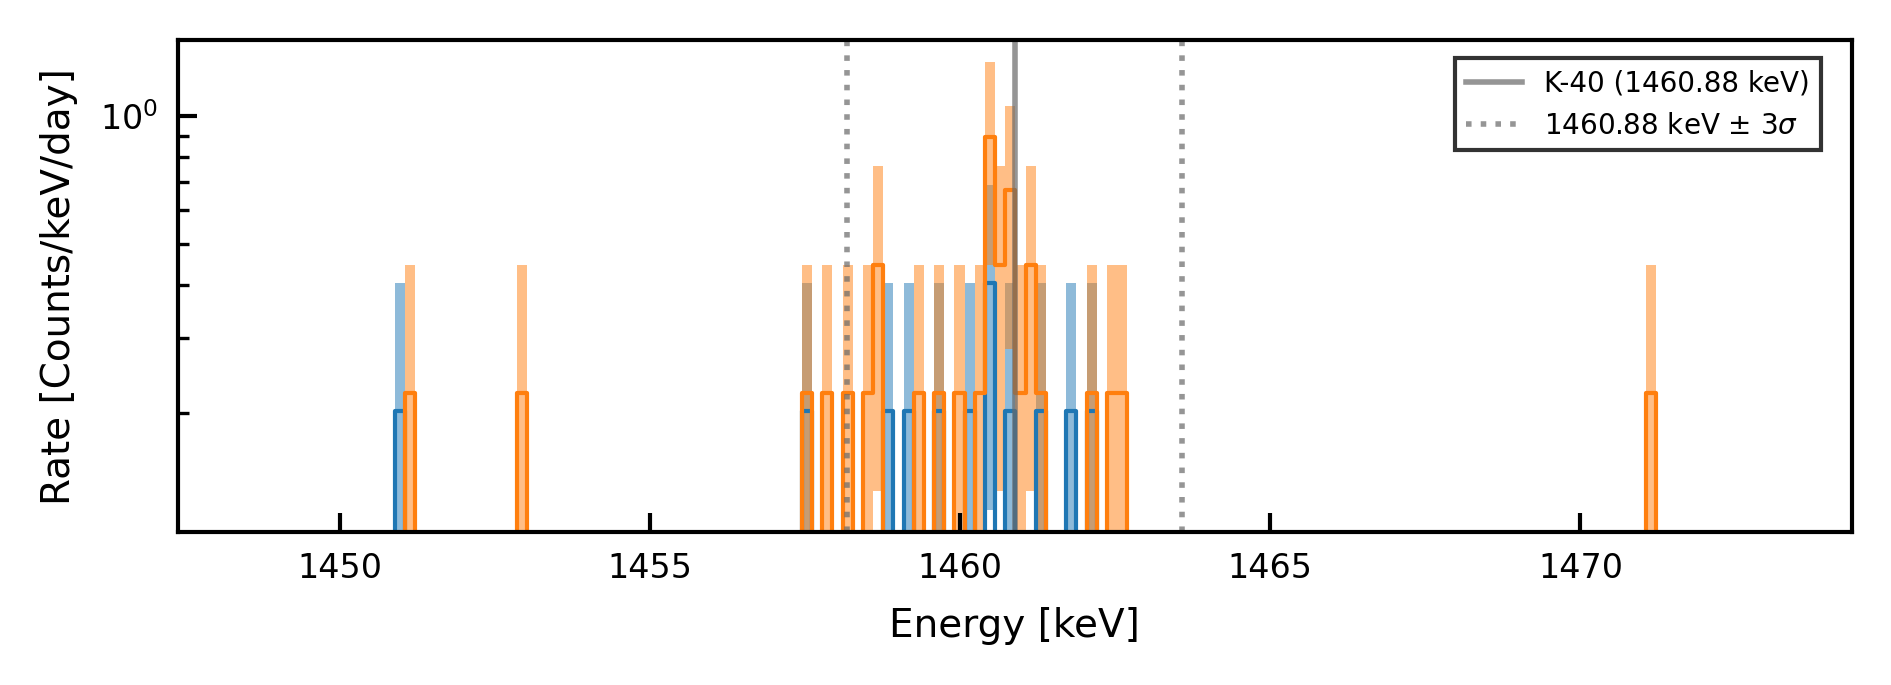

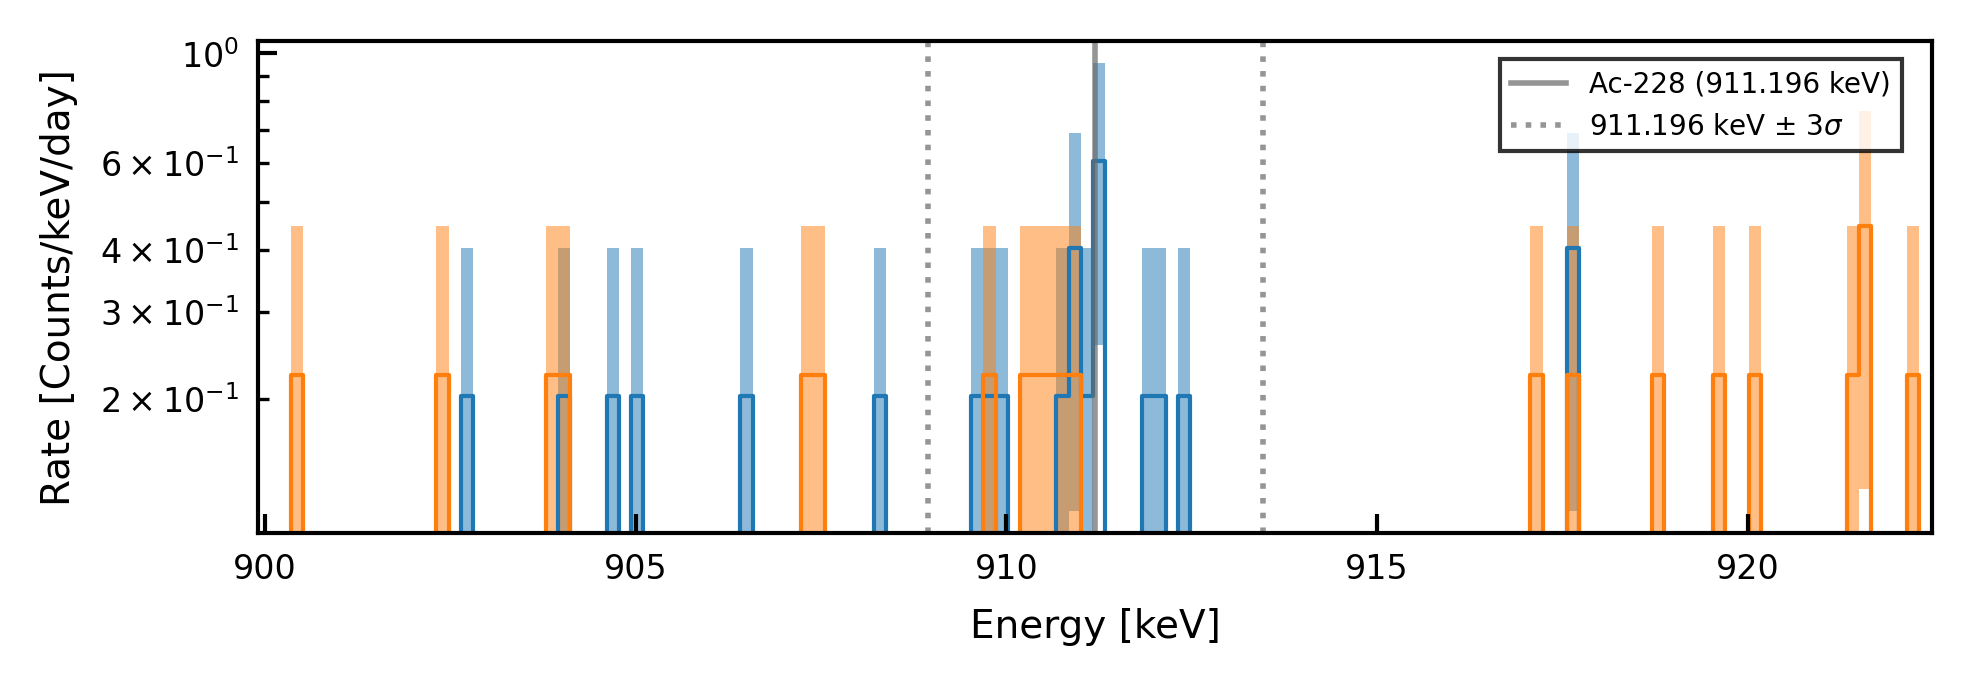

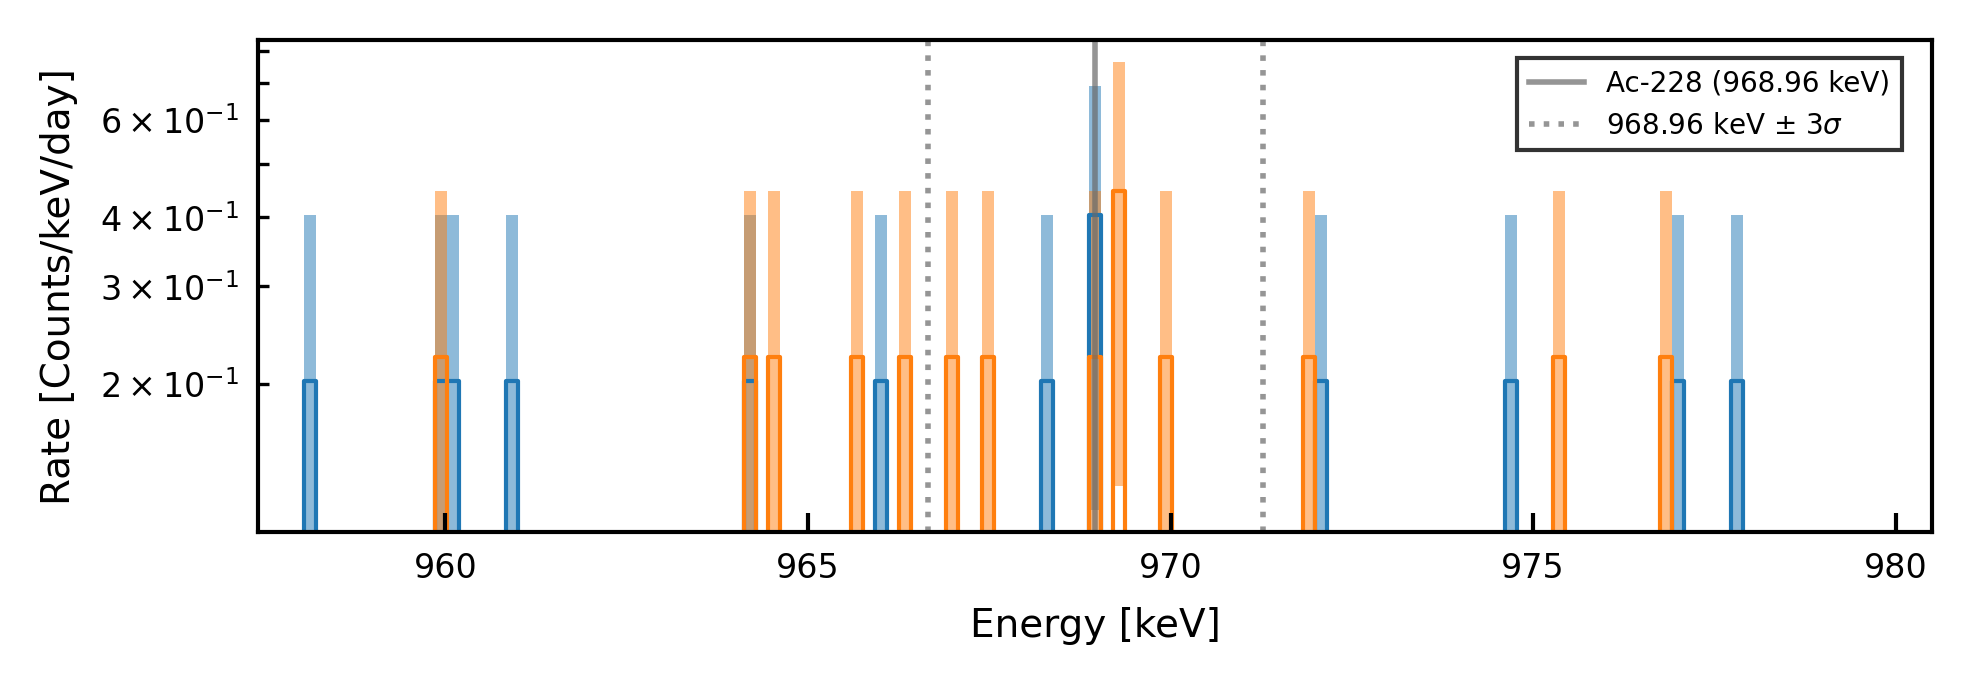

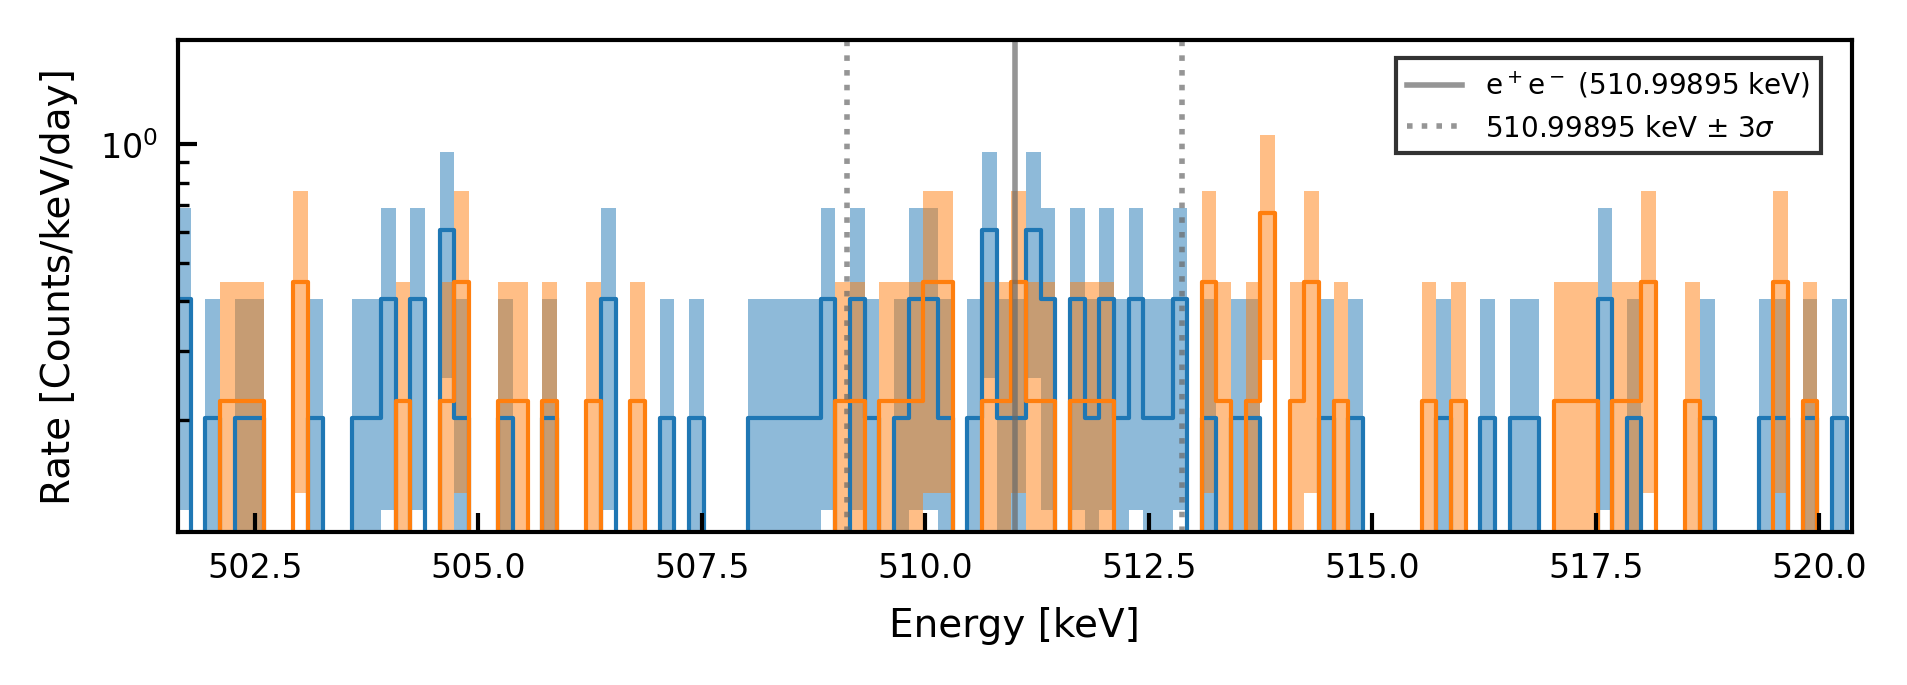

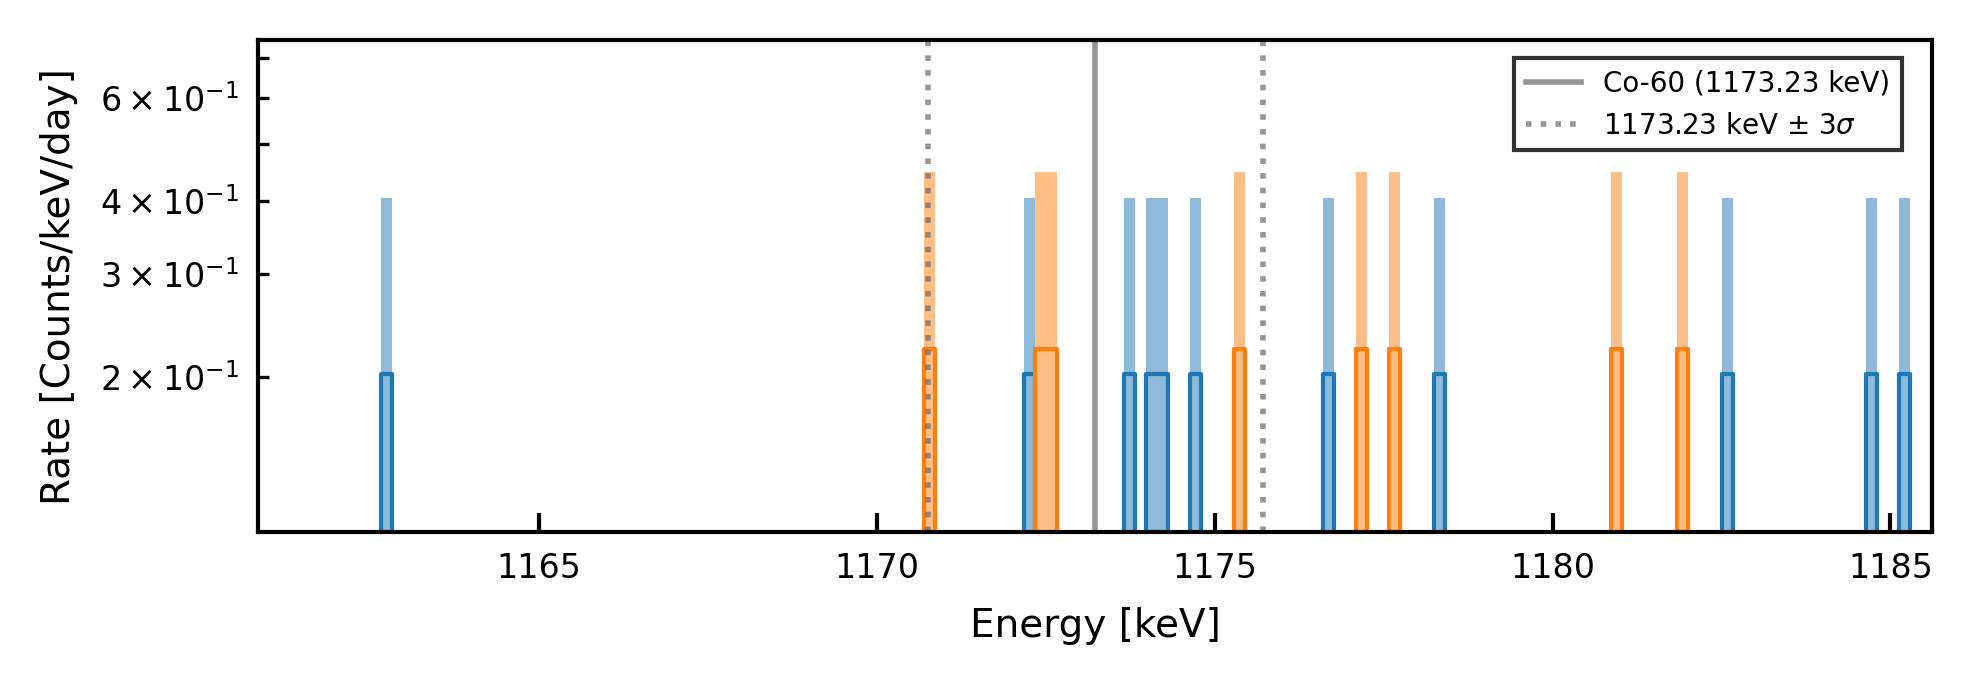

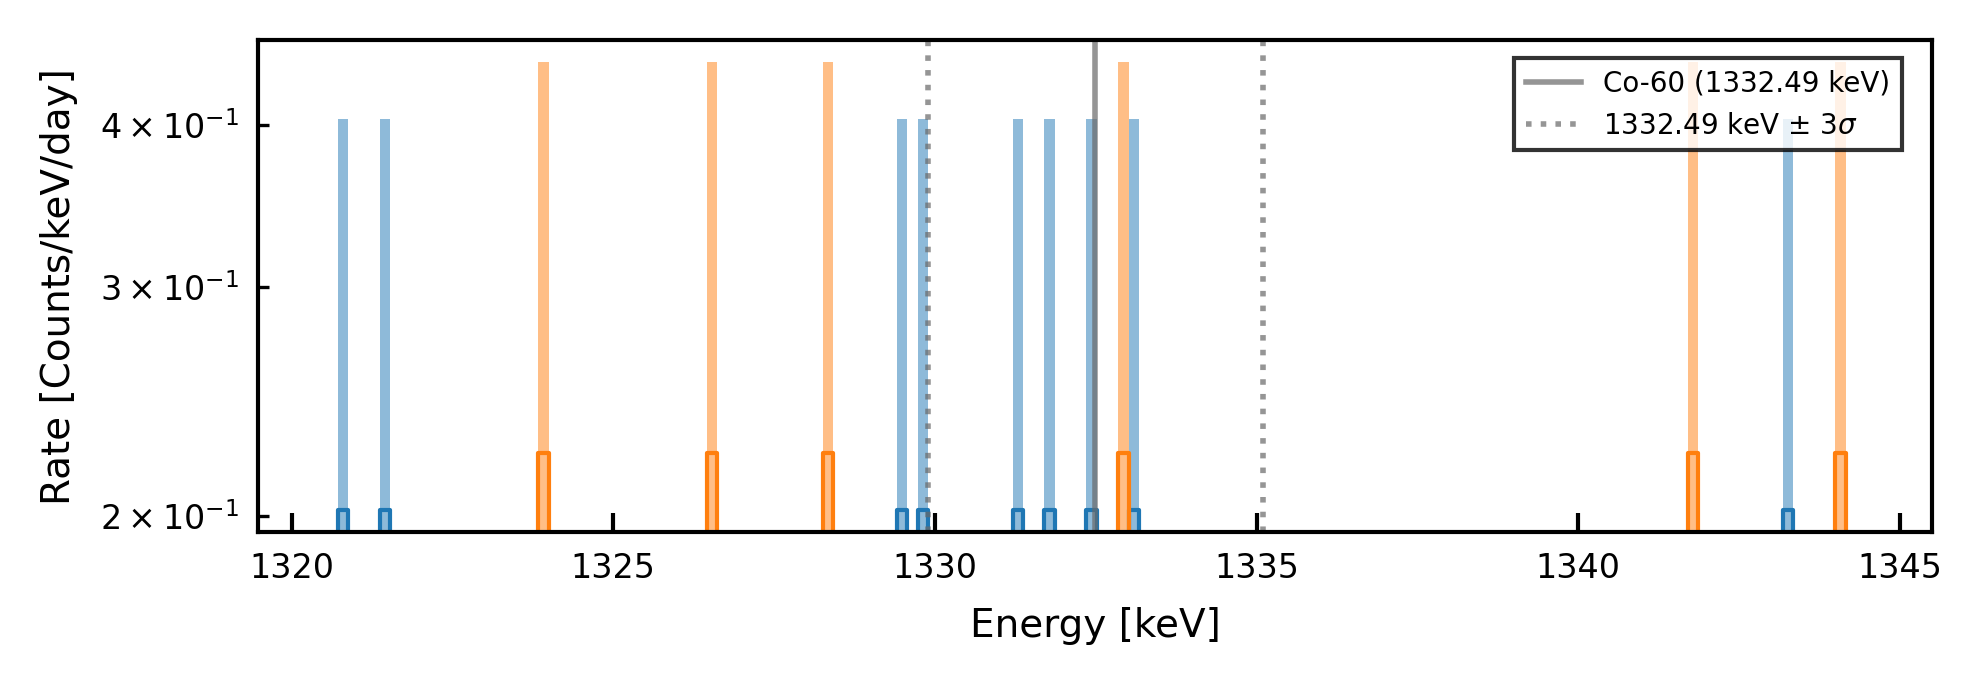

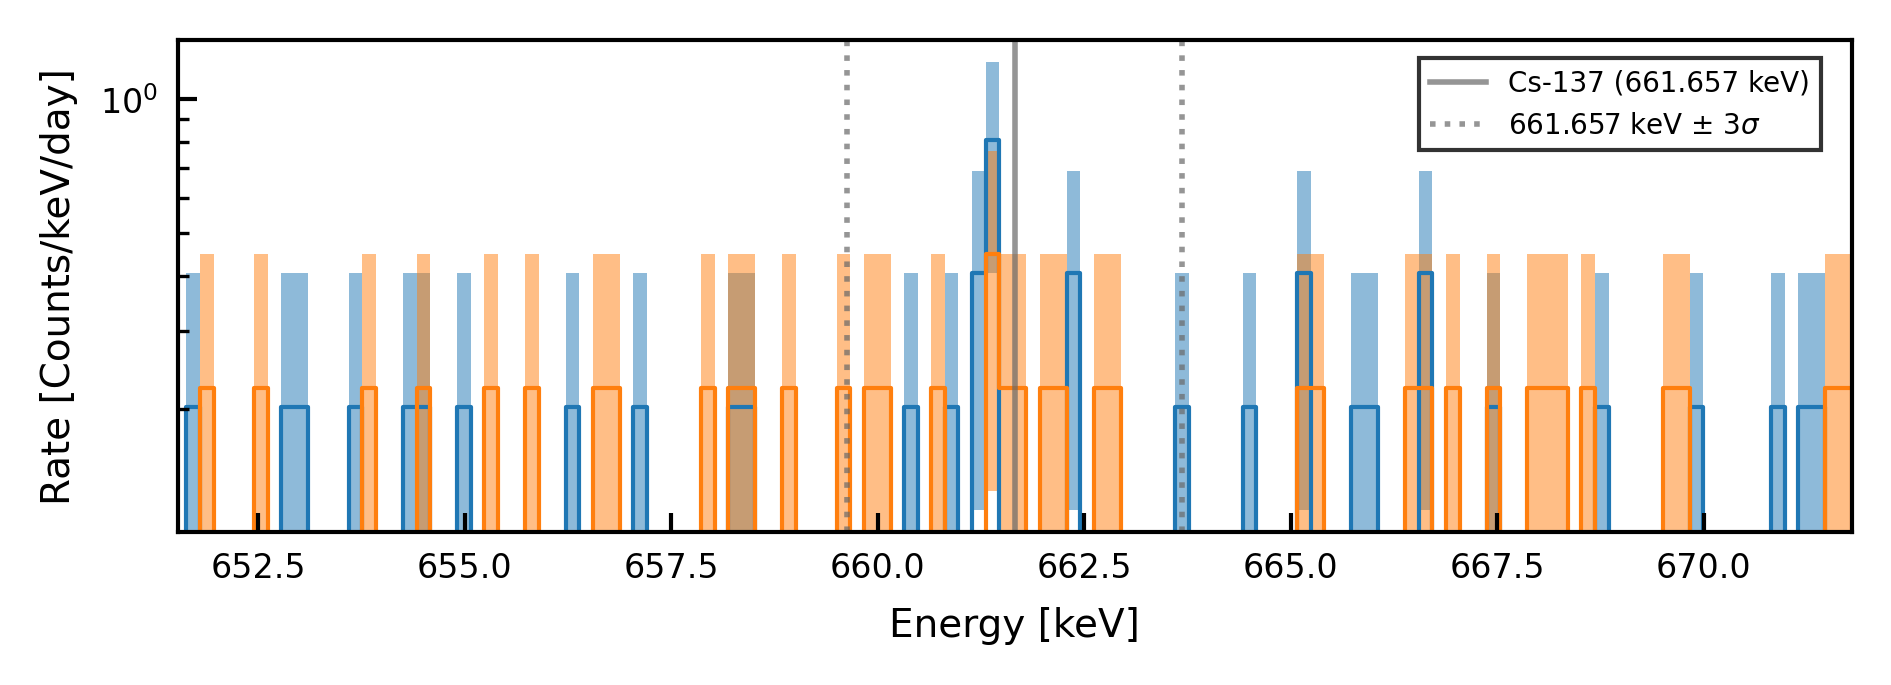

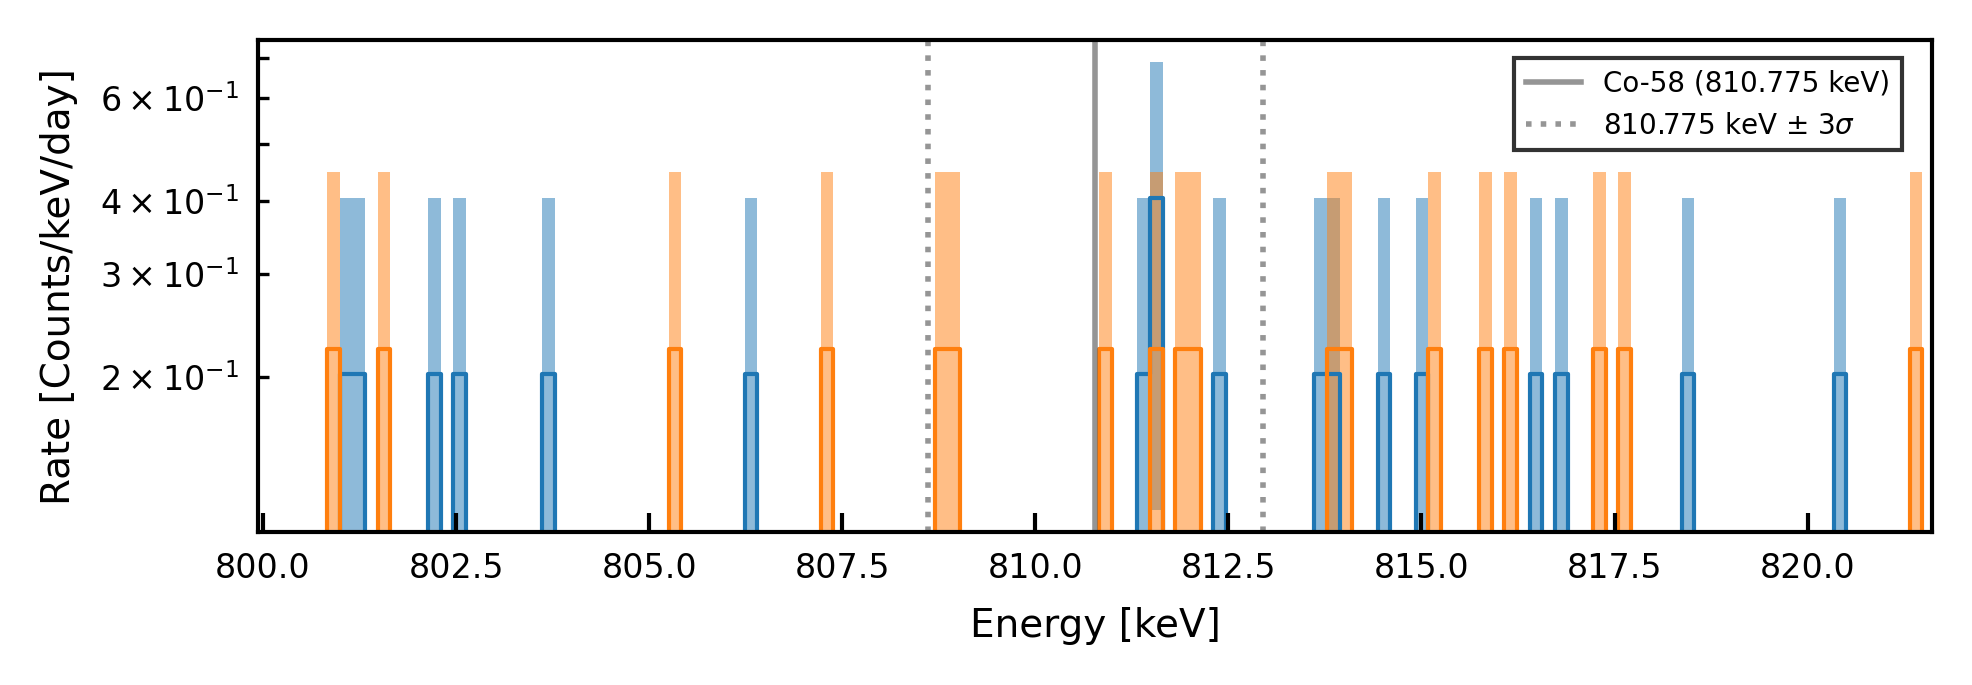

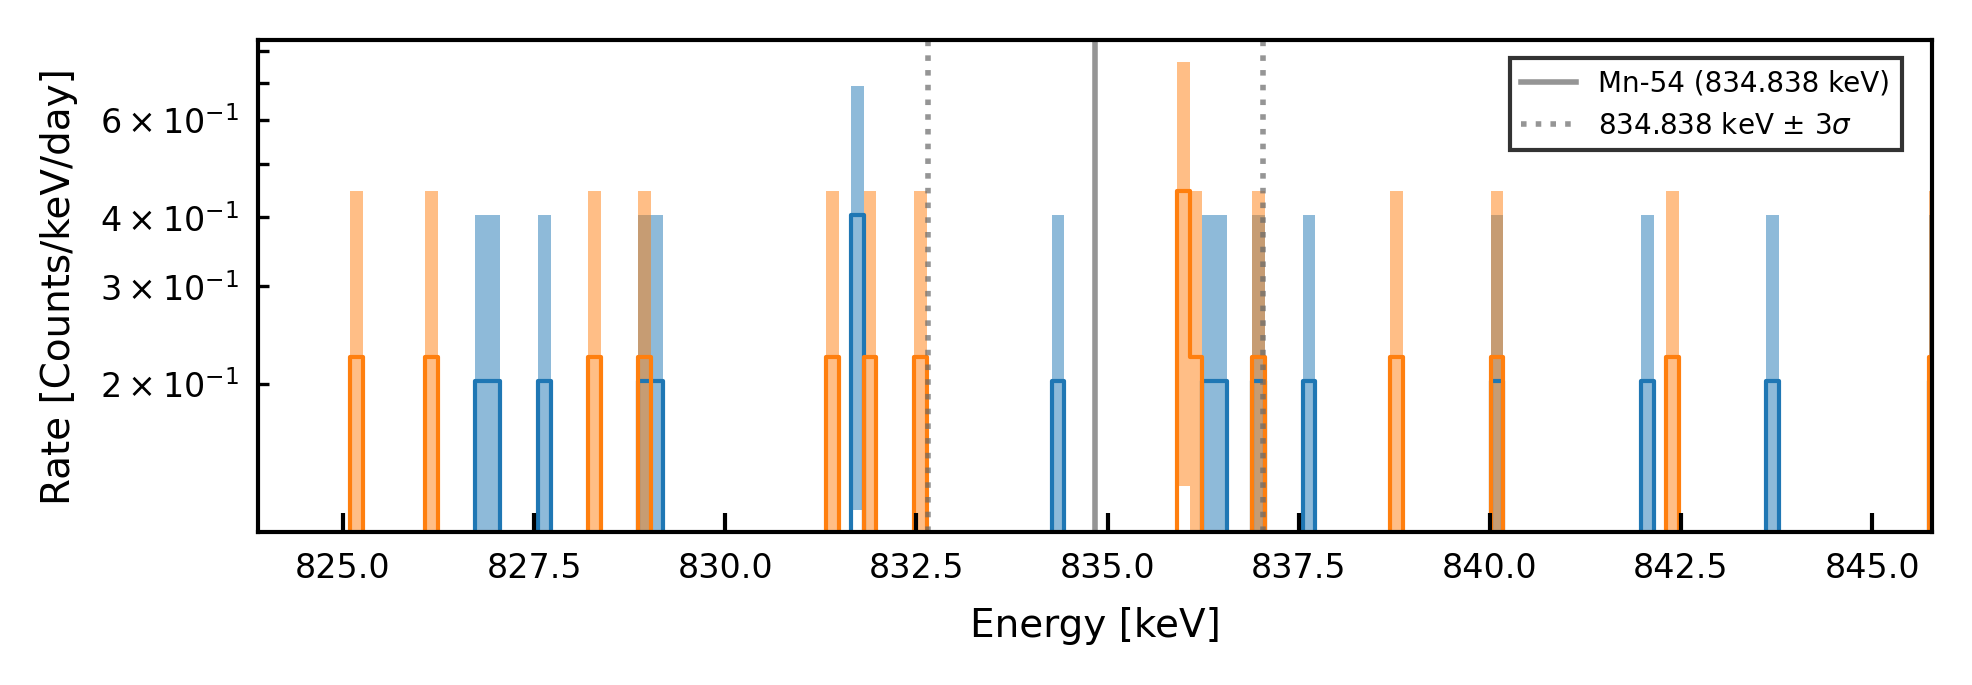

In [20]:
for lbl, en in np.array([df_lines.isotope, df_lines.energy]).T:
    df_sample_rebin = rebin_df(df_in = df_sample, size = 1)
    df_background_rebin = rebin_df(df_in = df_background, size = 1)

    df_sample_rebin = df_sample_rebin[(df_sample_rebin.energy > (en - 20* resolFunc(en))) & (df_sample_rebin.energy <  (en + 20* resolFunc(en)))]
    df_background_rebin = df_background_rebin[(df_background_rebin.energy > (en - 20* resolFunc(en))) & (df_background_rebin.energy <  (en + 20* resolFunc(en)))]

    
    f = plt.figure(figsize=(27/5,8/5), dpi=400)
    ax = f.add_subplot(111)

    plt.step(df_background_rebin.energy, df_background_rebin.rate, 
             where='mid', linewidth = 0.75, color = 'C0')
    plt.fill_between(df_background_rebin.energy, df_background_rebin.rate - df_background_rebin.rate_err, 
                     df_background_rebin.rate + df_background_rebin.rate_err, 
                     step="mid", color = 'C0', alpha=0.5, linewidth = 0)
    plt.step(df_sample_rebin.energy, df_sample_rebin.rate, 
             where='mid', linewidth = 0.75, color = 'C1')
    plt.fill_between(df_sample_rebin.energy, df_sample_rebin.rate - df_sample_rebin.rate_err, 
                     df_sample_rebin.rate + df_sample_rebin.rate_err, 
                     step="mid", color = 'C1', alpha=0.5, linewidth = 0)

    ####################

    en = en
    isotope = lbl
    plt.axvline(en, color = 'dimgray', linestyle = '-', linewidth = 1, alpha = 0.7, label = isotope+' ('+str(en)+' keV)')
    plt.axvline(en + 3* resolFunc(en), color = 'dimgray', linestyle = 'dotted', linewidth = 1, alpha = 0.7, label = str(en)+' keV $\pm$ $3\sigma$')
    plt.axvline(en - 3* resolFunc(en), color = 'dimgray', linestyle = 'dotted', linewidth = 1, alpha = 0.7)


    ####################

    #ax.xaxis.set_major_locator(MultipleLocator(500))
    #ax.xaxis.set_minor_locator(MultipleLocator(100))

    plt.yscale('log')
    #plt.ylim(2e-1, 1e3)
    plt.xlabel('Energy [keV]')
    plt.ylabel('Rate [Counts/keV/day]')

    plt.xlim(en - 15* resolFunc(en), en + 15* resolFunc(en))

    legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
    legend.get_frame().set_linewidth(0.75)

    #plt.savefig('plots/spectrum_'+save_name+'_'+isotope+'_'+str(int(en))+'.png', transparent=True, bbox_inches='tight')
    #plt.savefig('plots/spectrum_'+save_name+'_'+isotope+'_'+str(int(en))+'.pdf', transparent=True, bbox_inches='tight')

    plt.show()

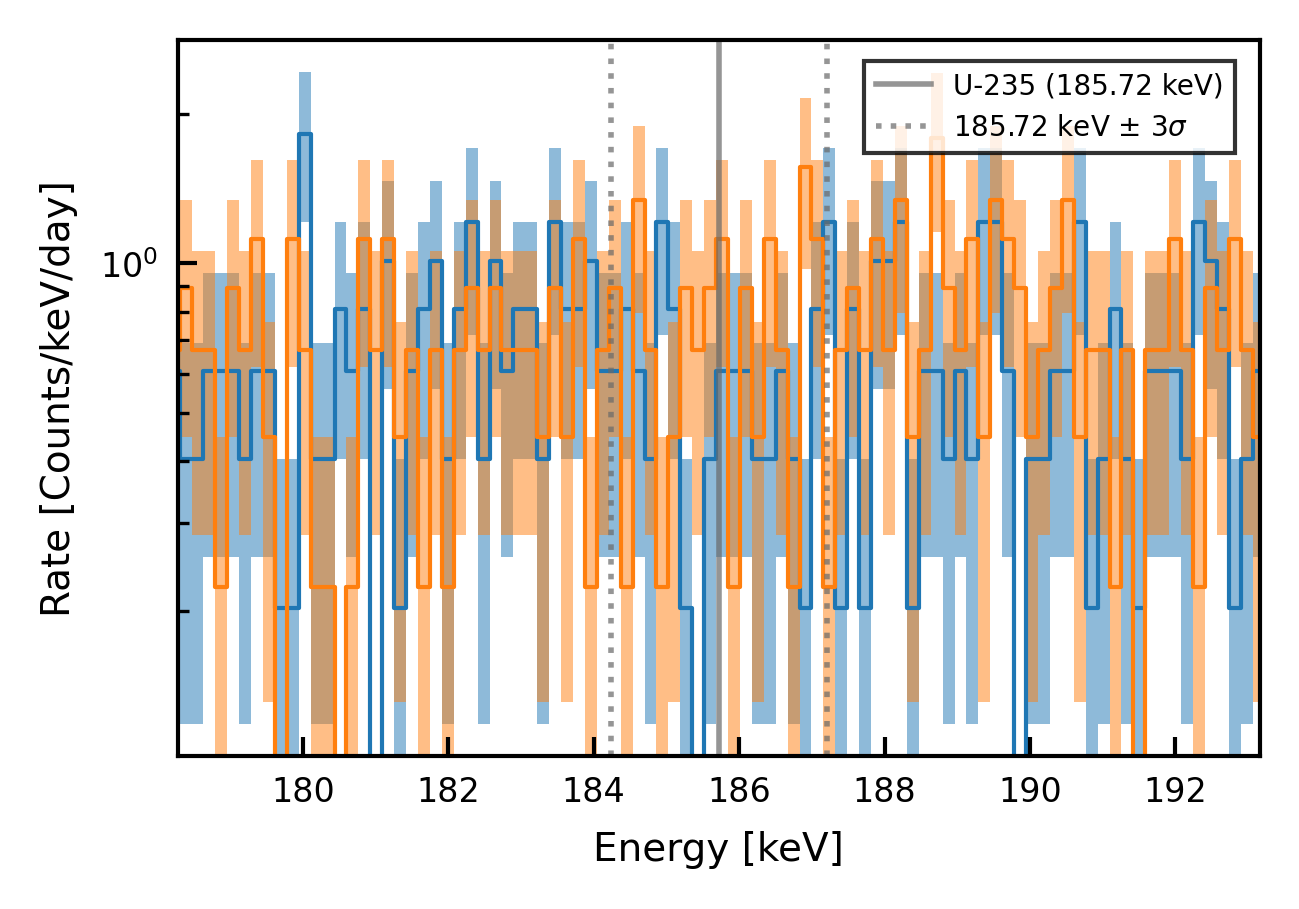

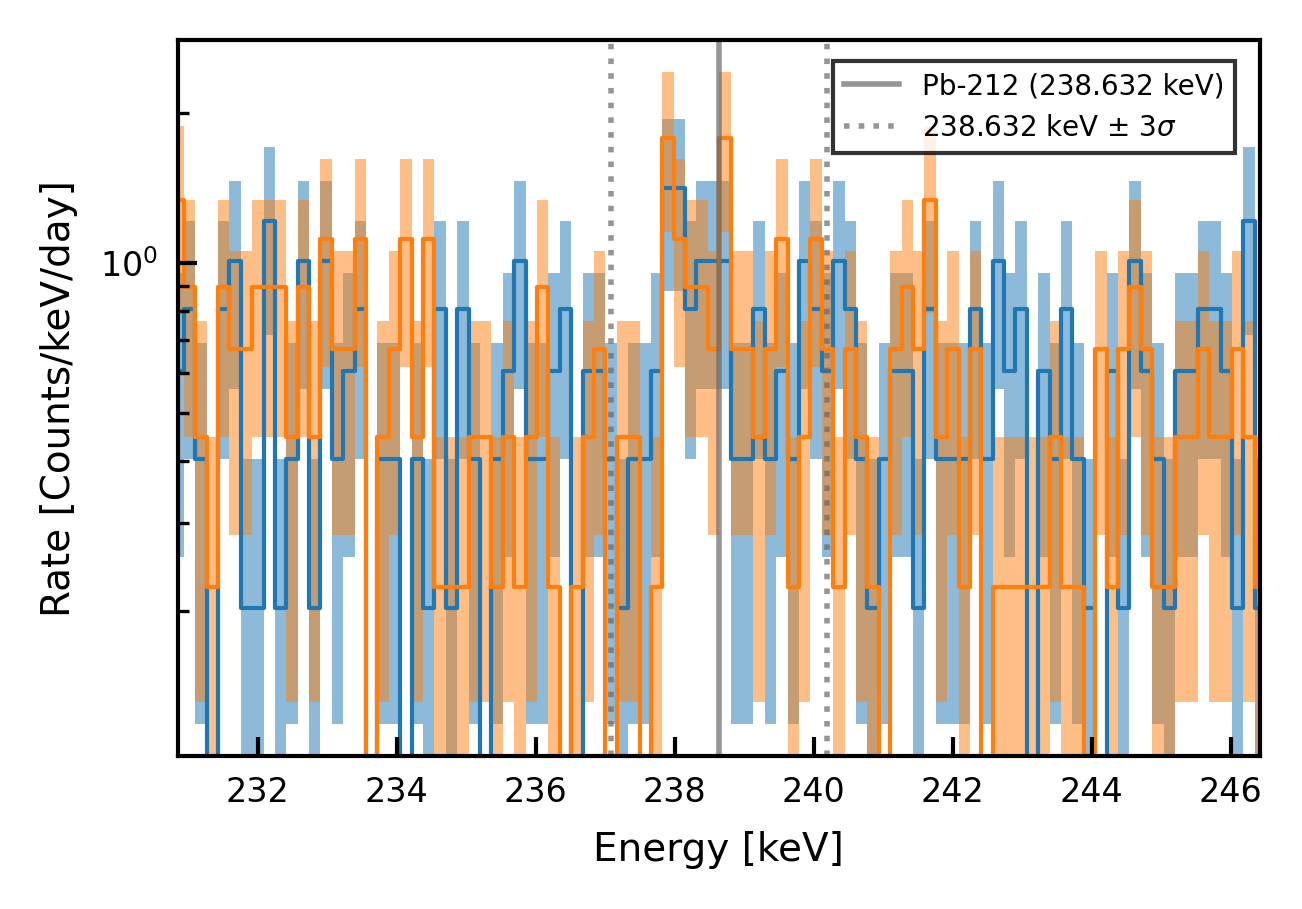

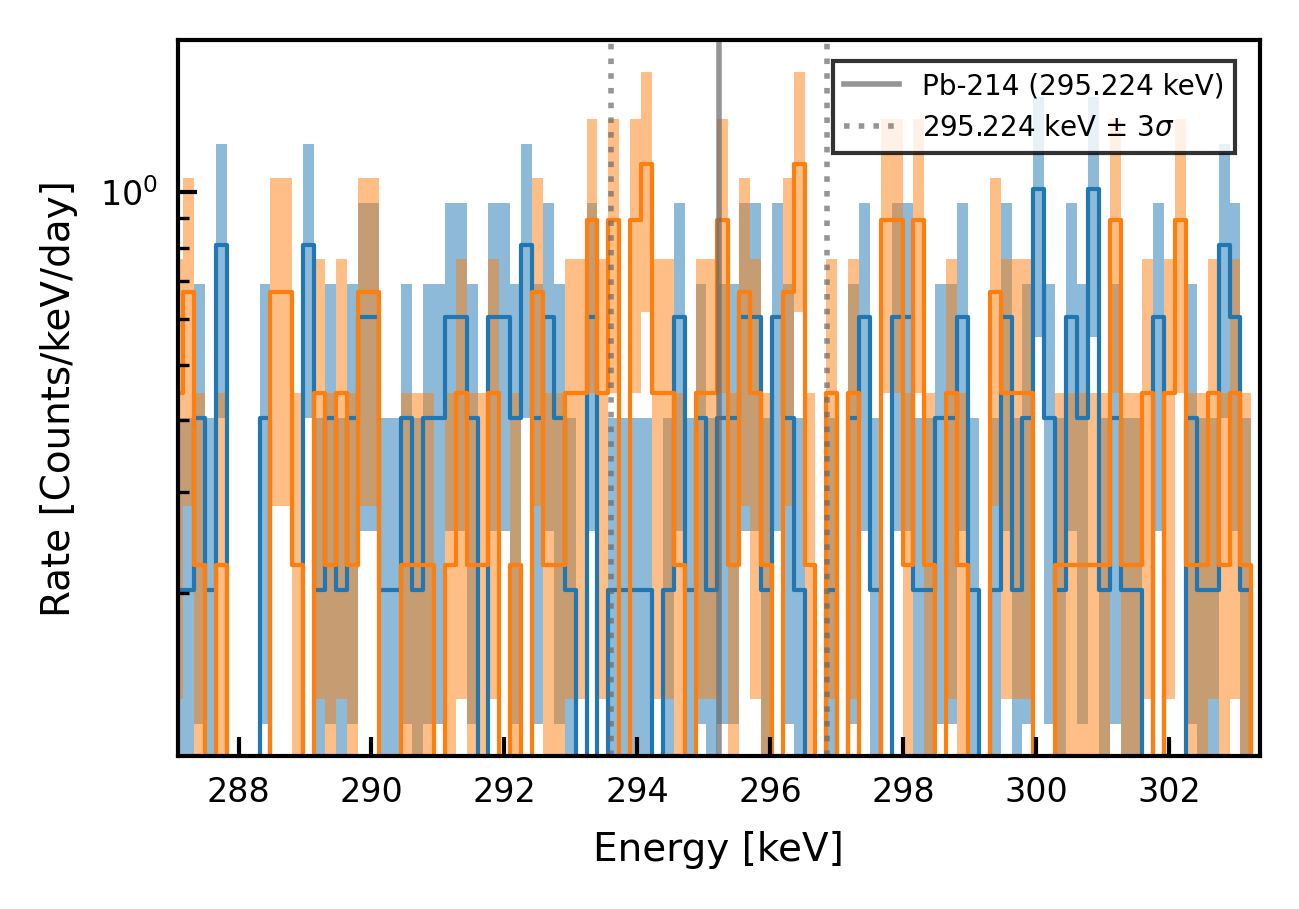

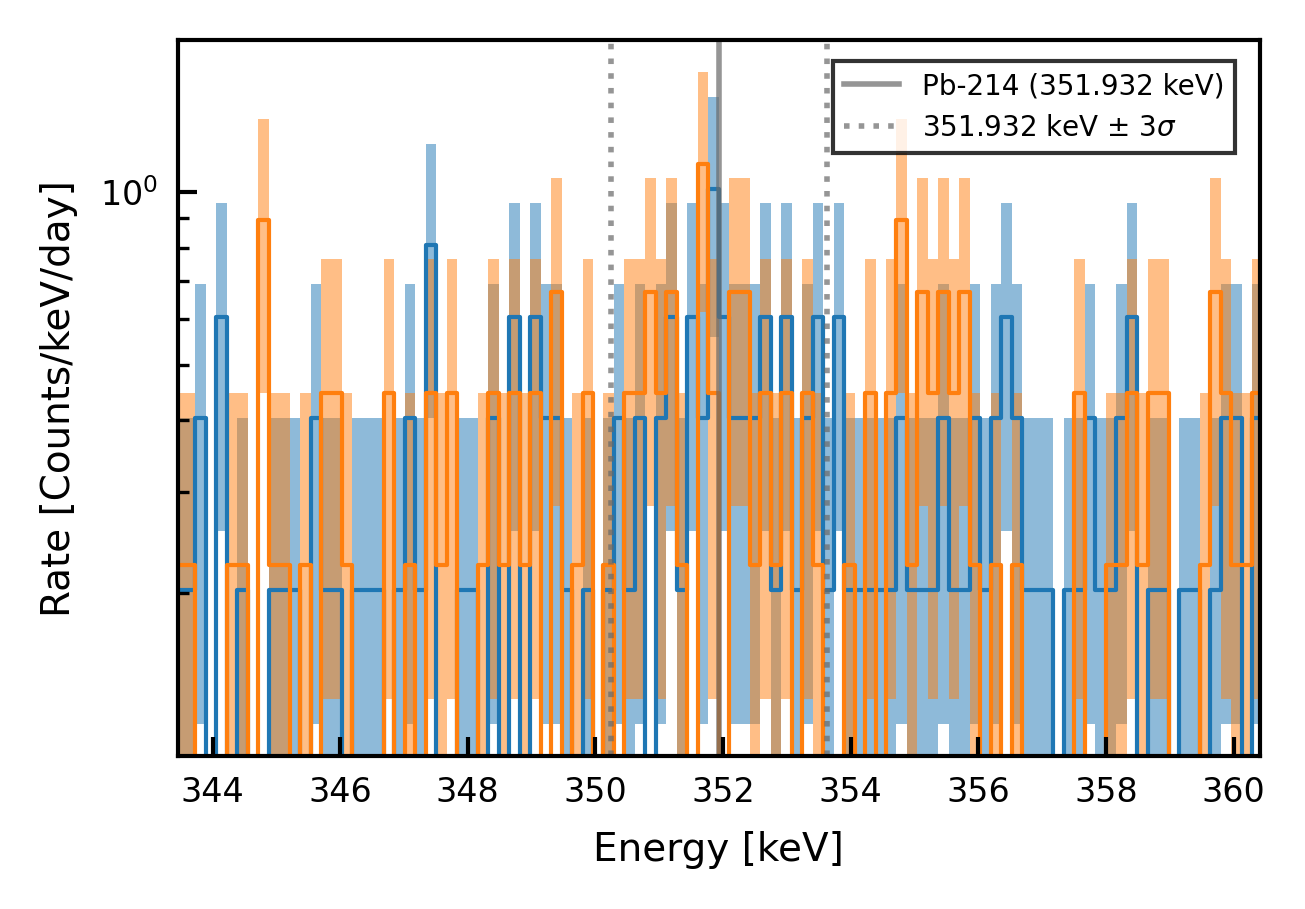

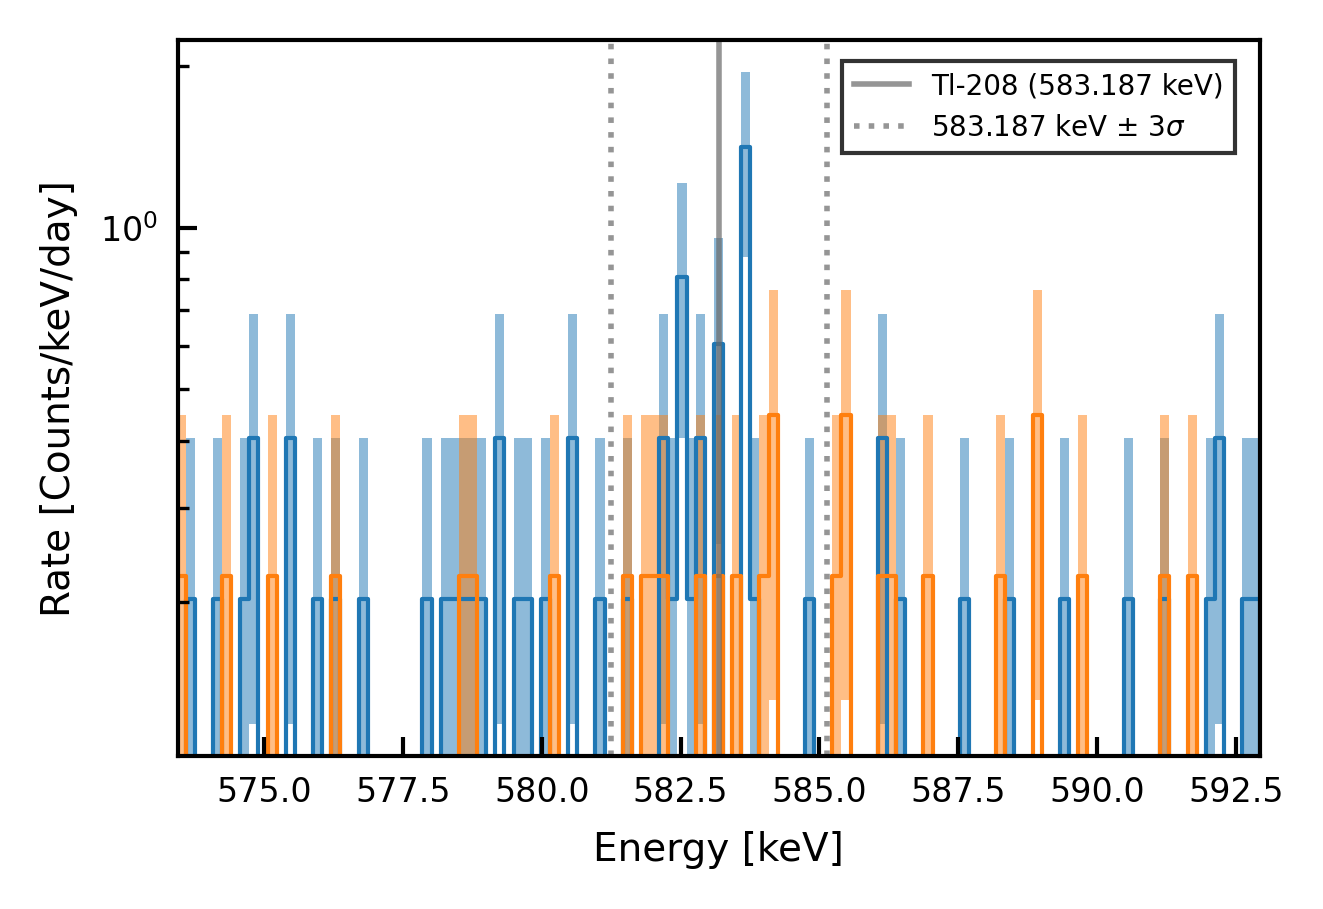

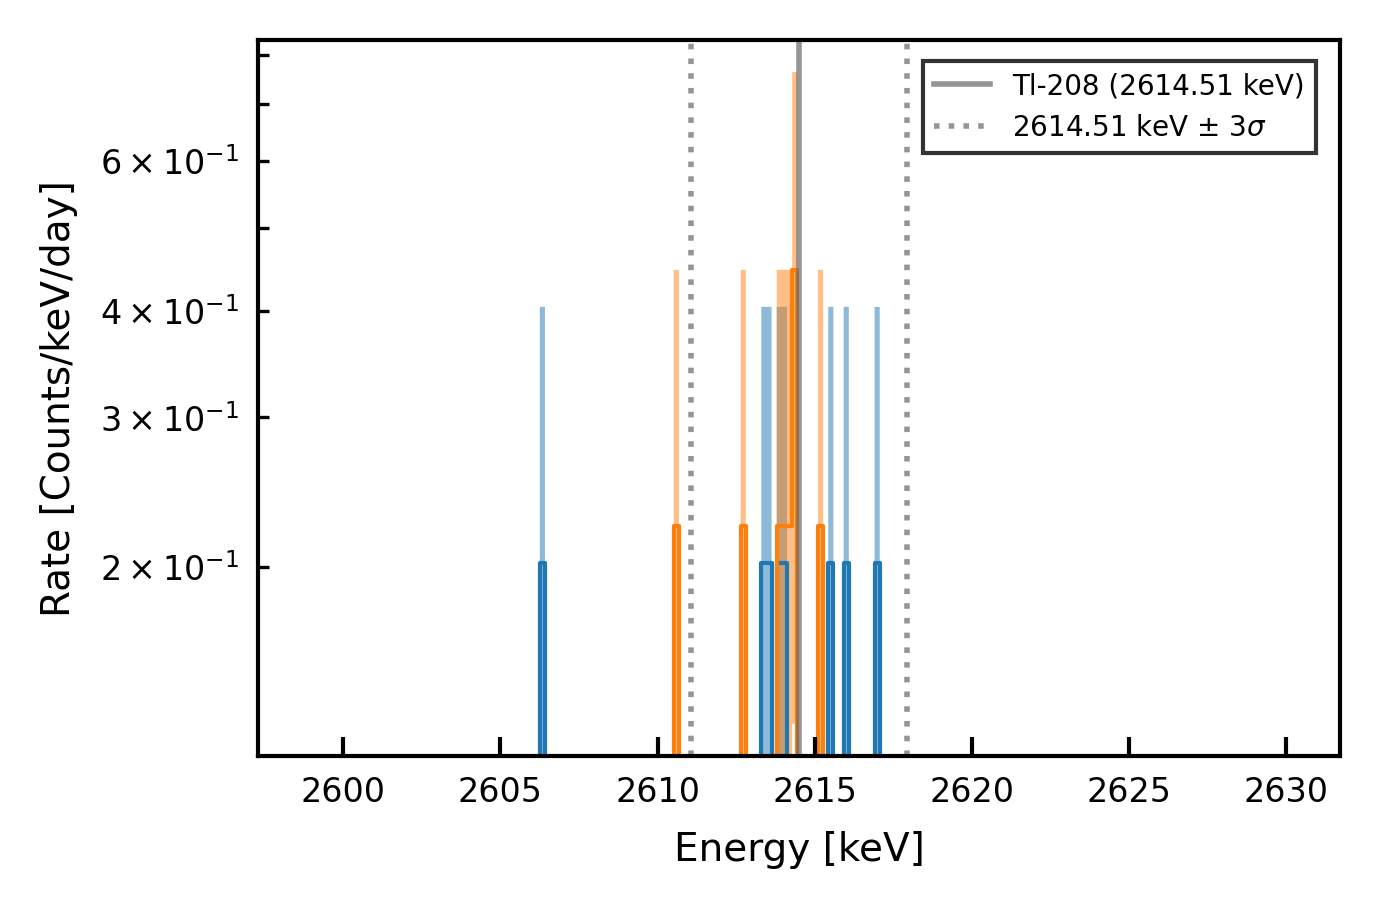

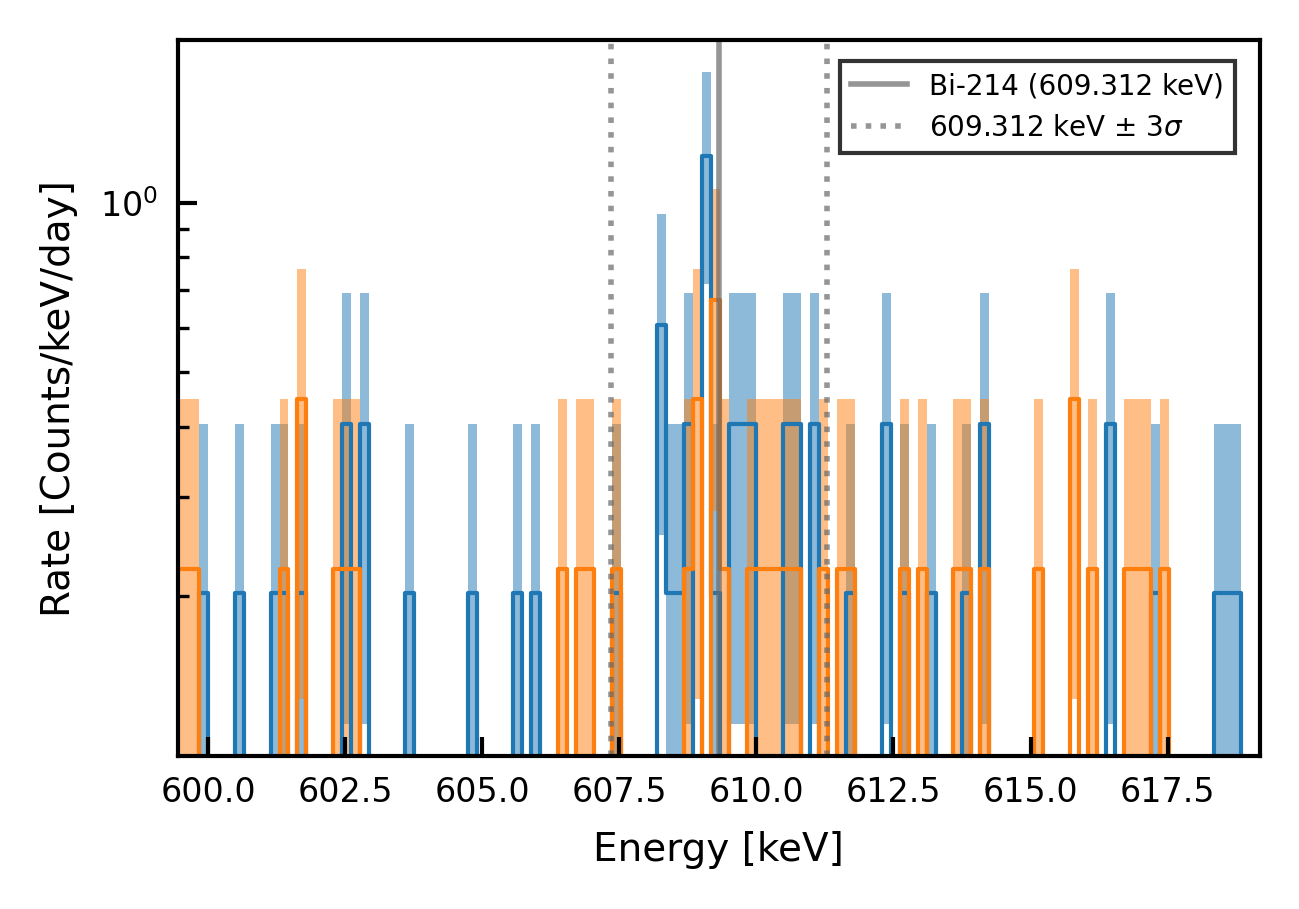

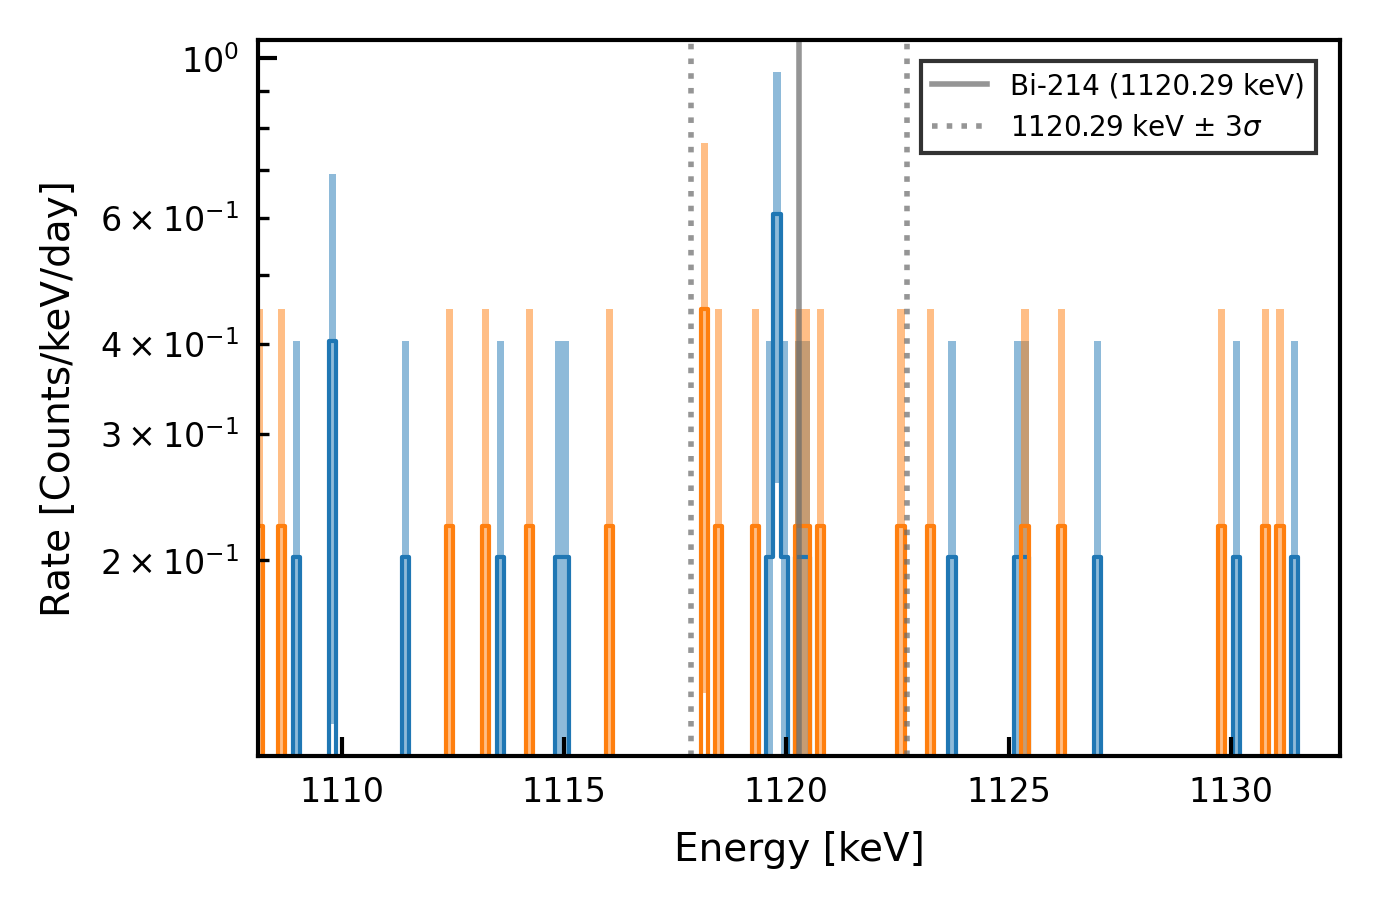

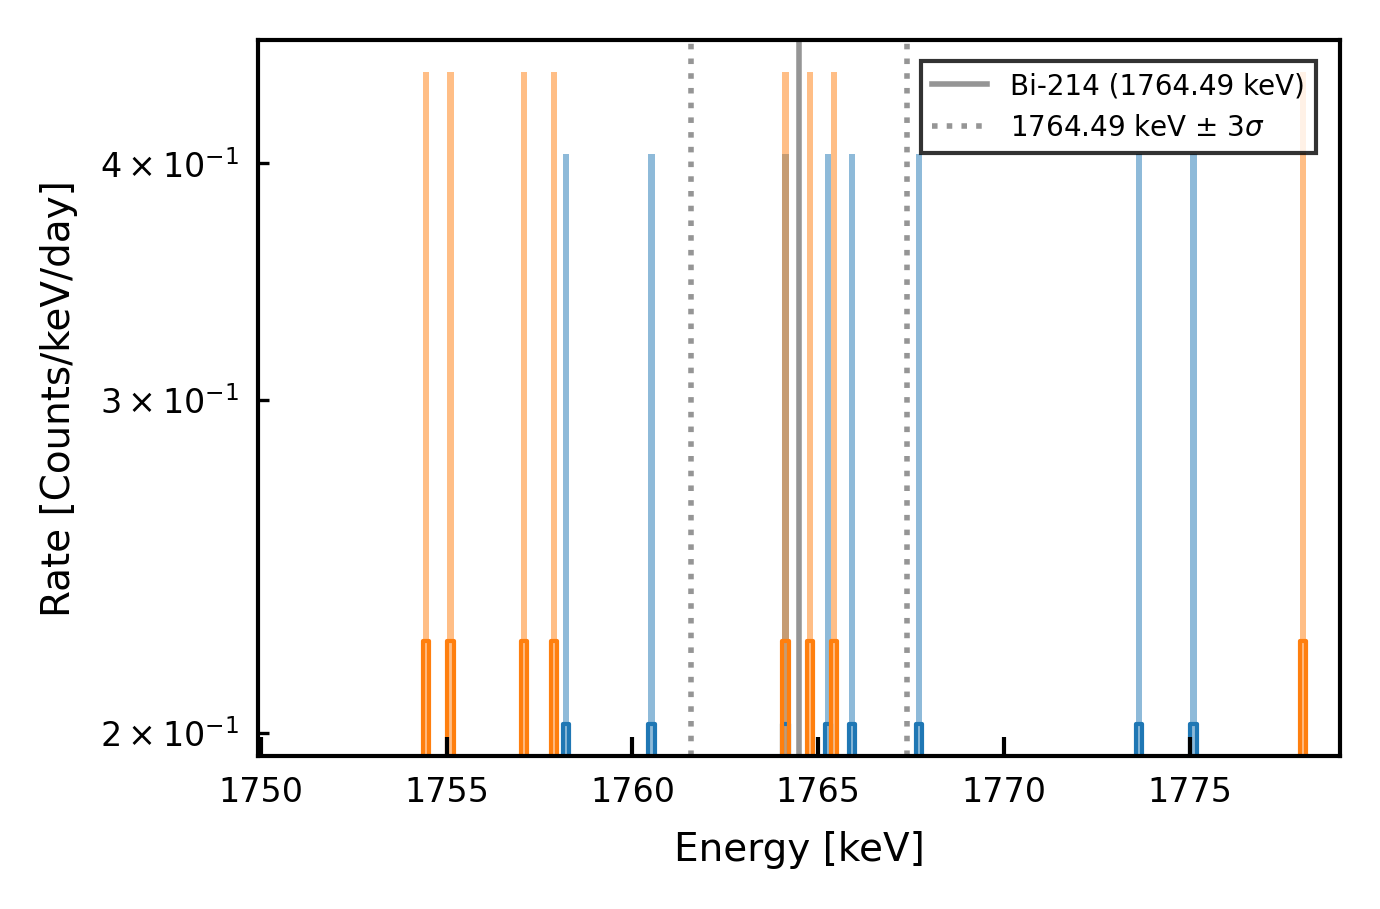

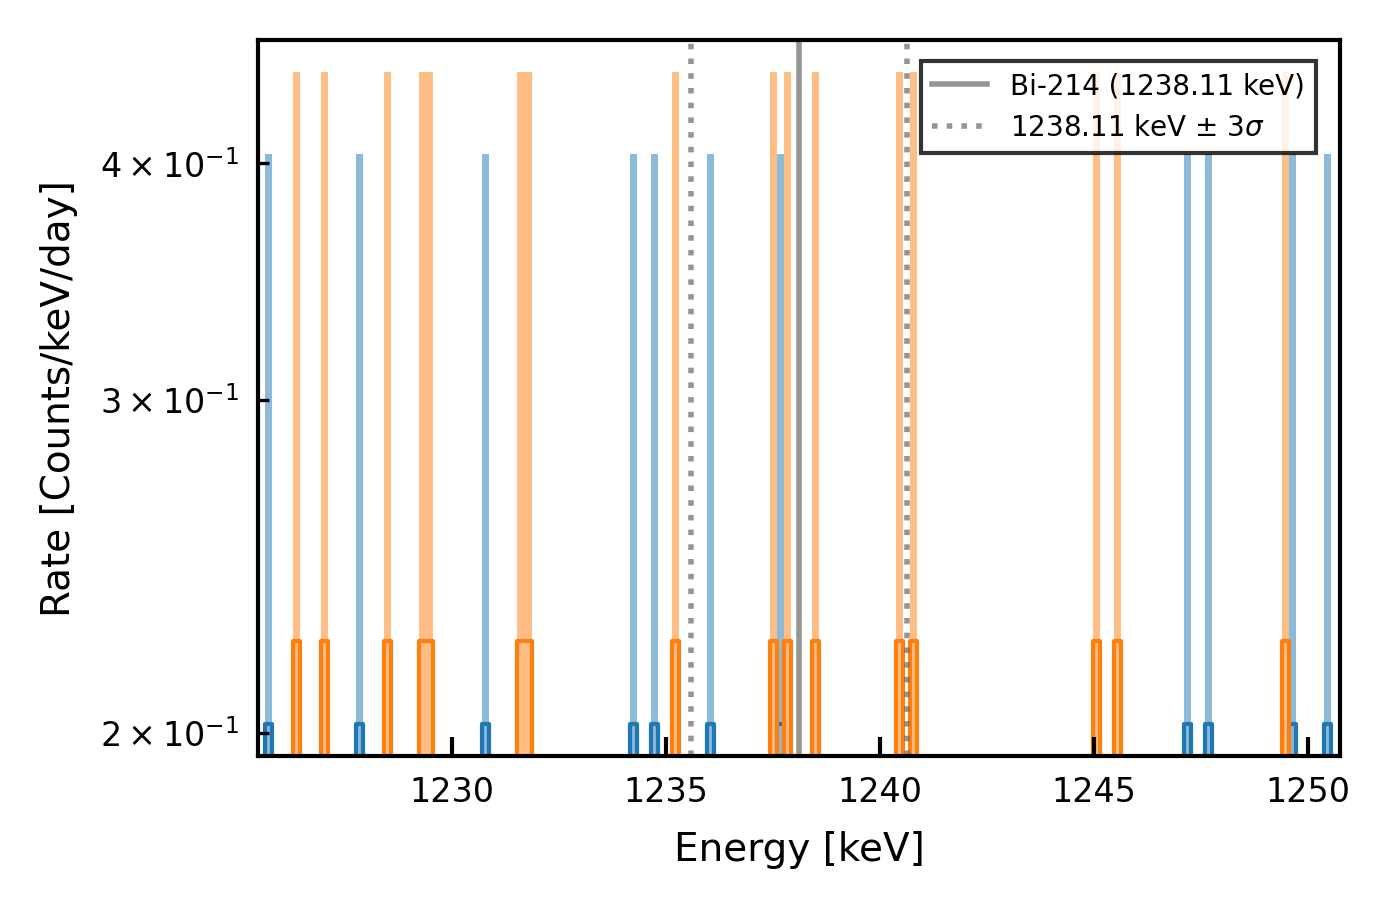

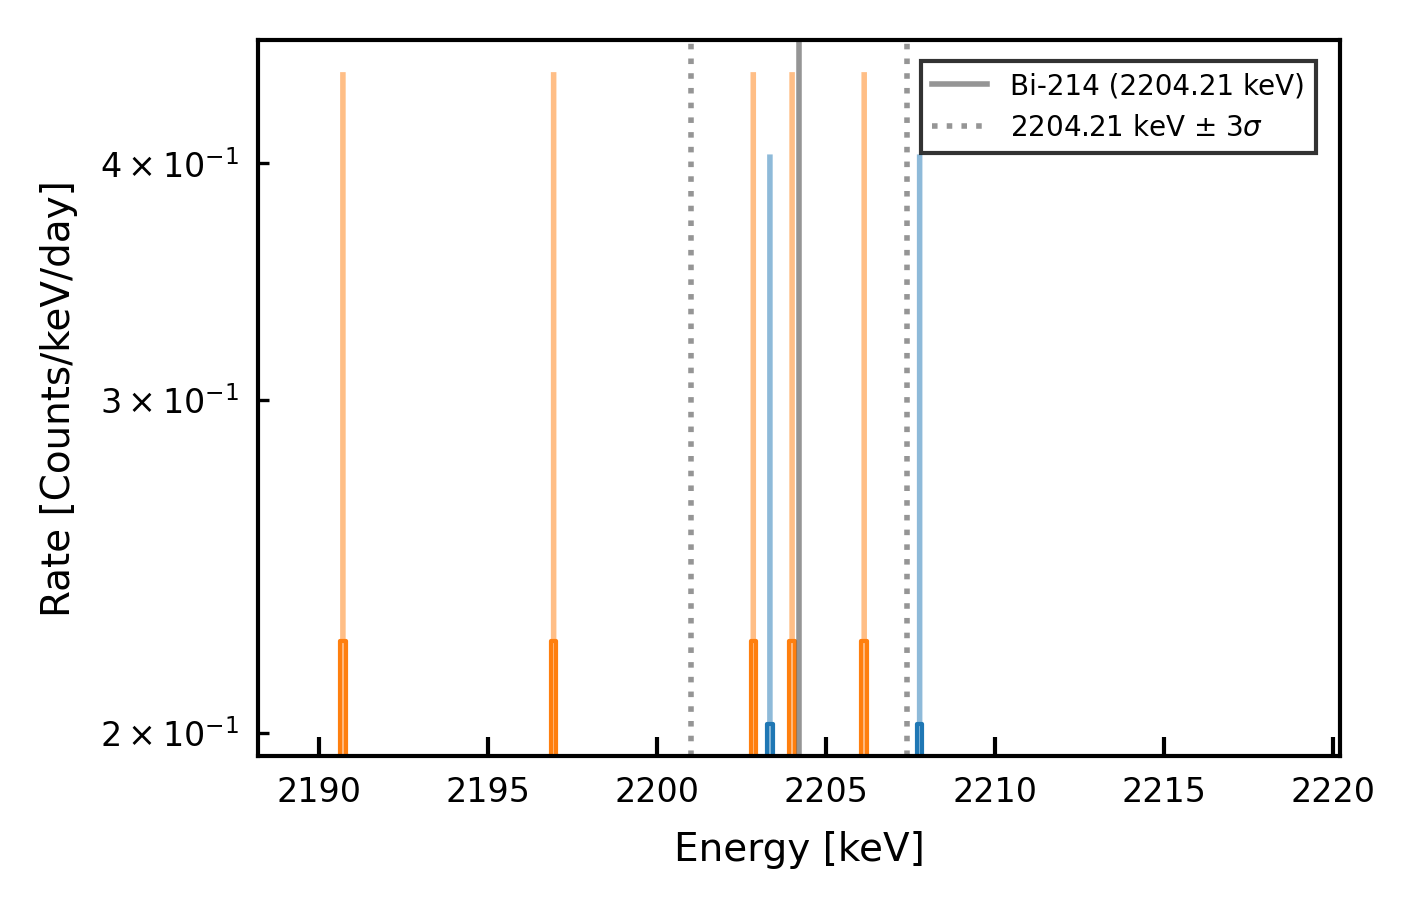

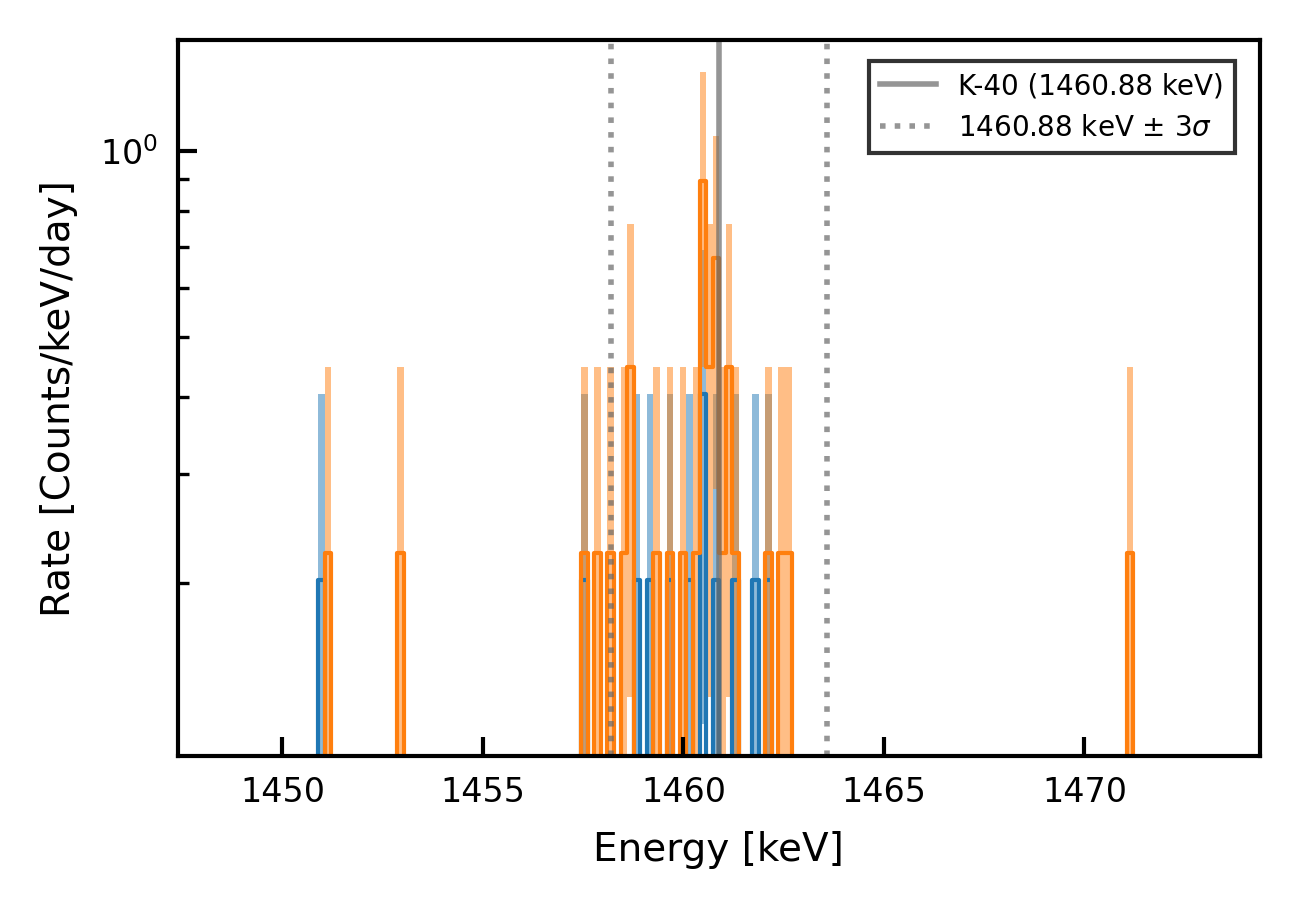

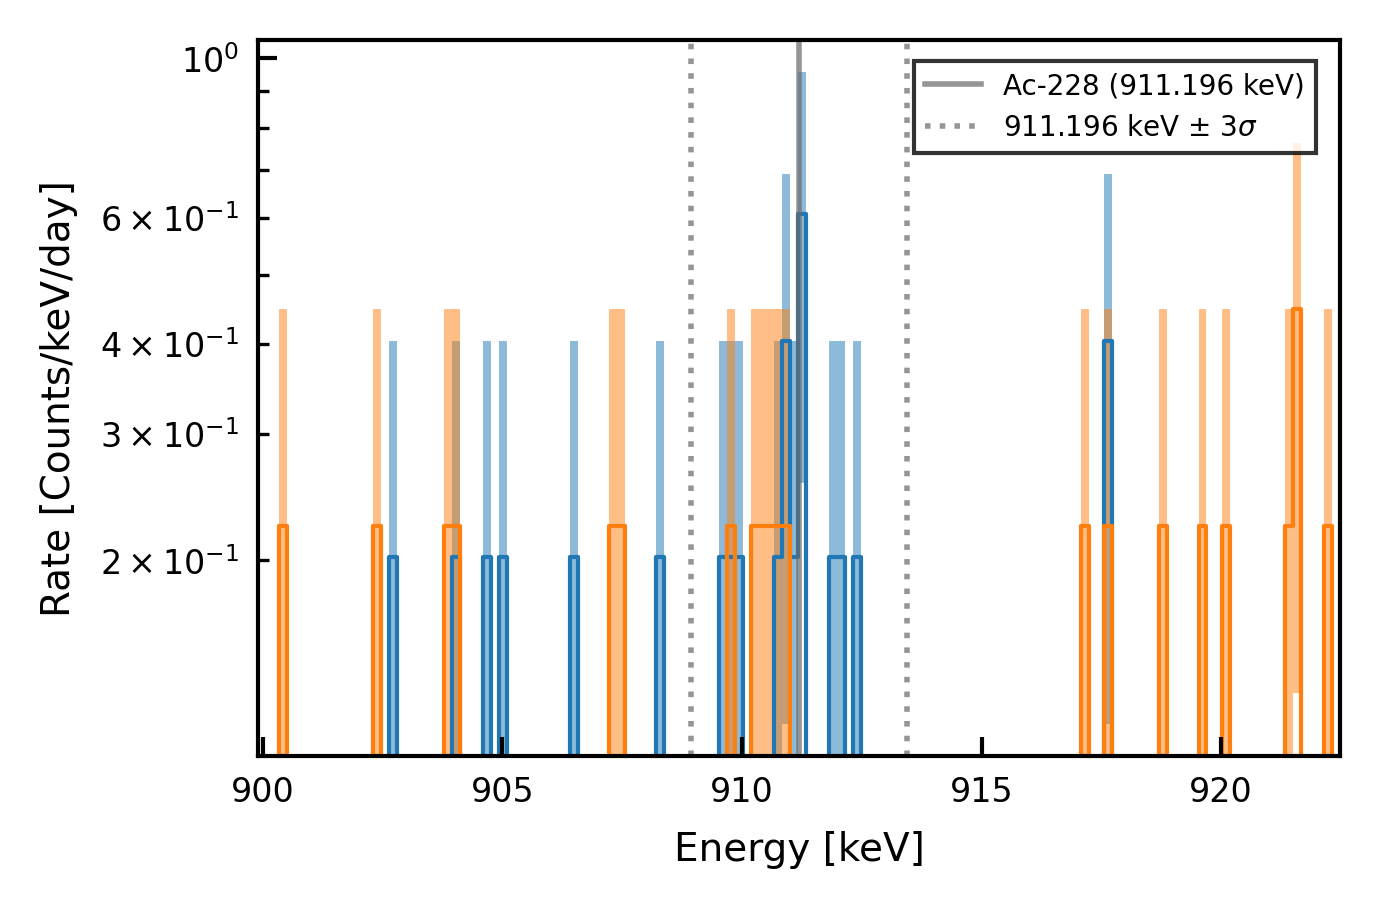

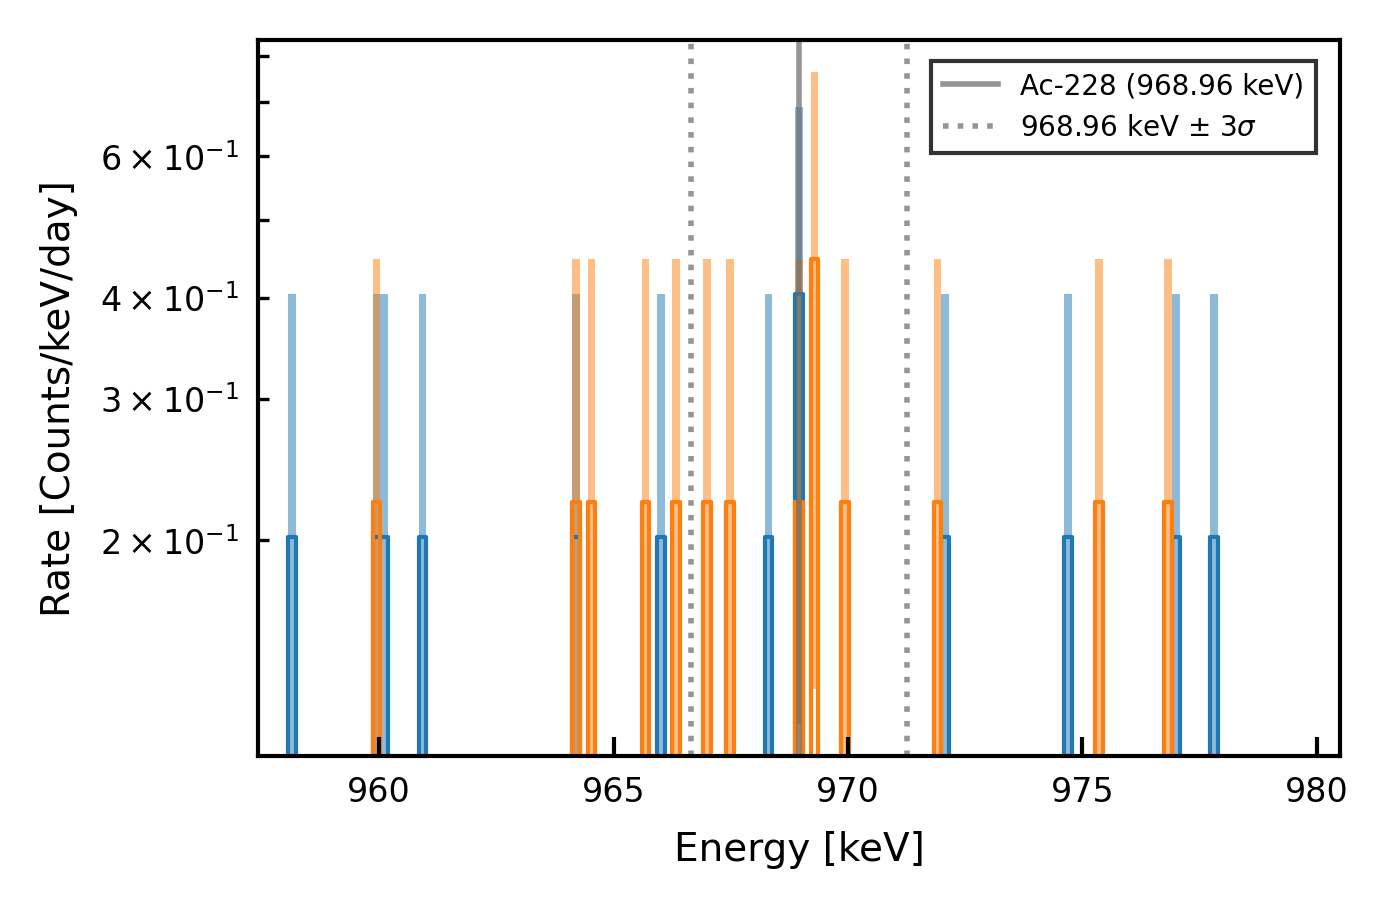

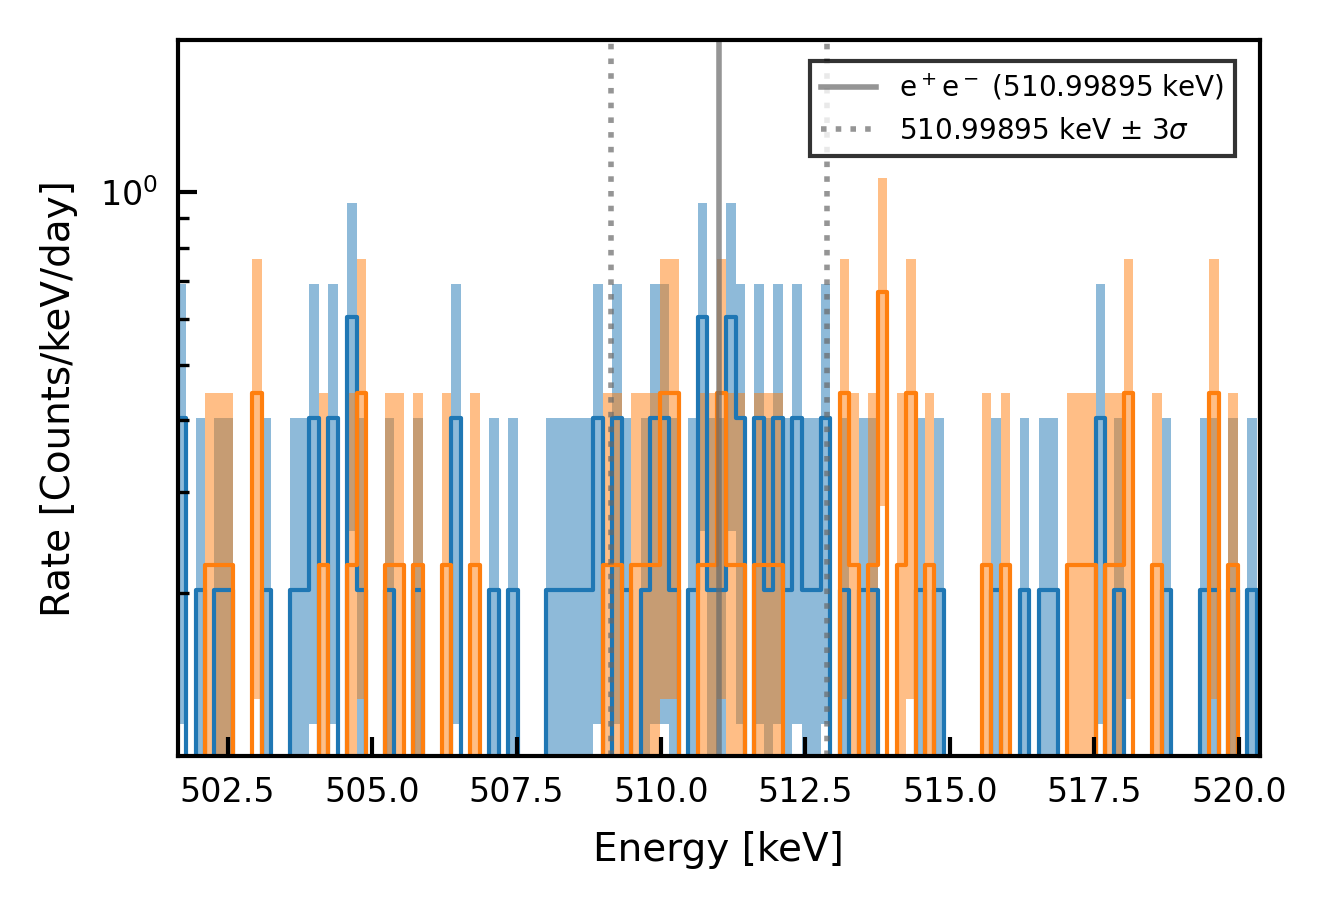

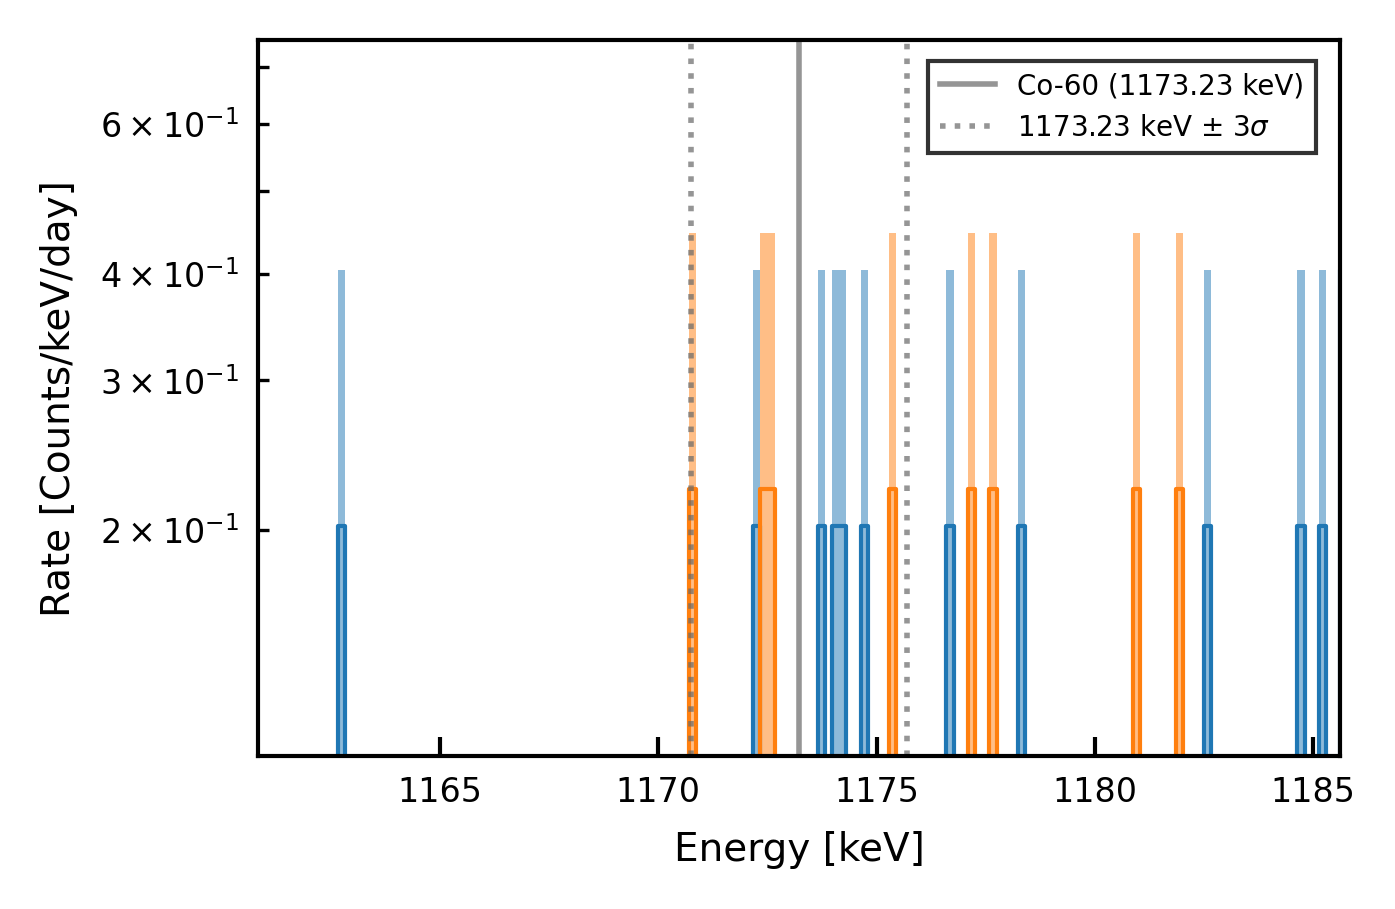

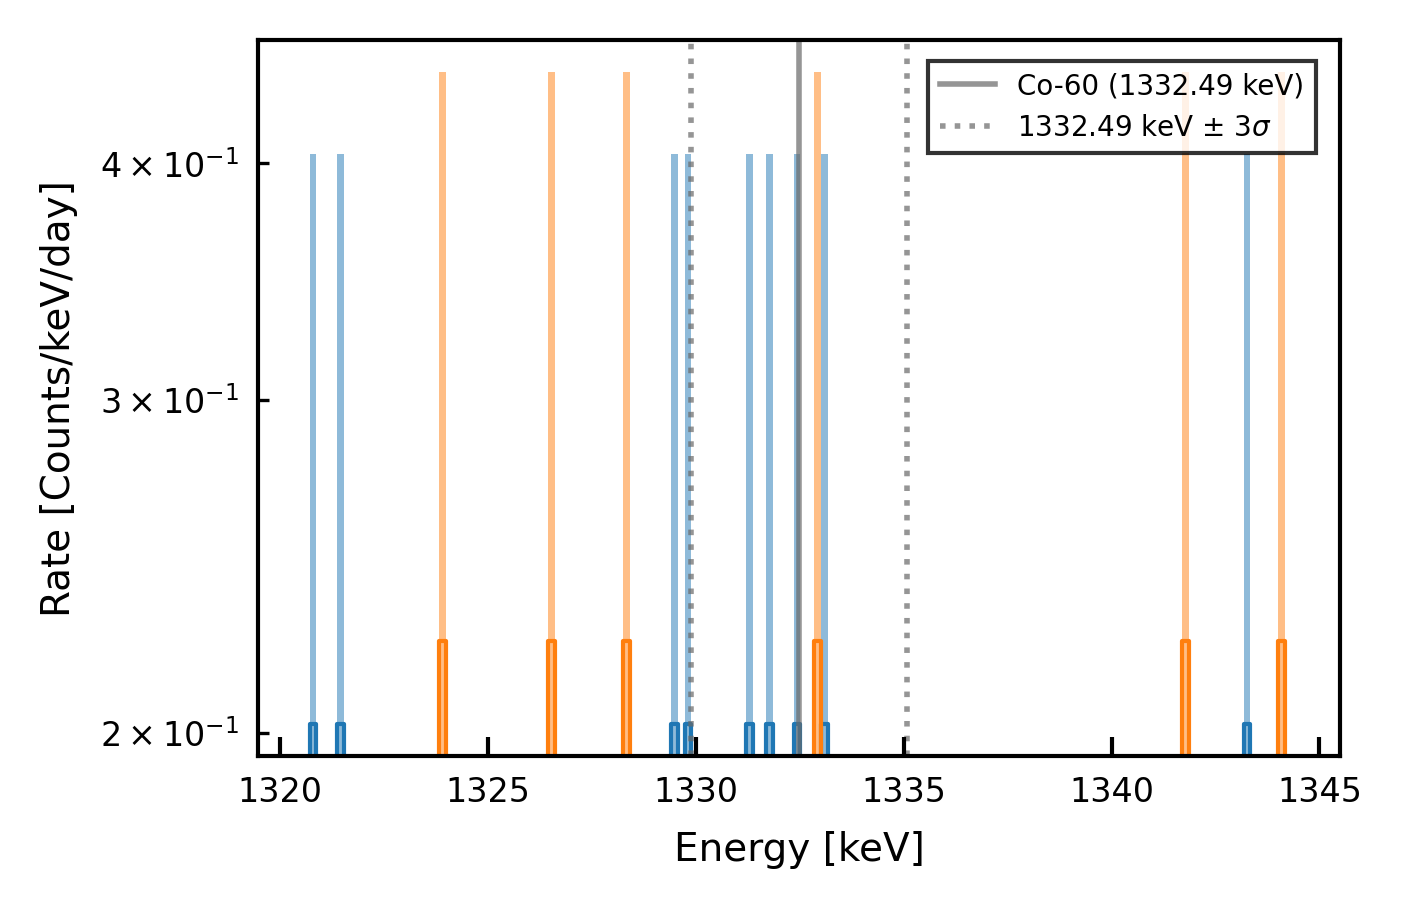

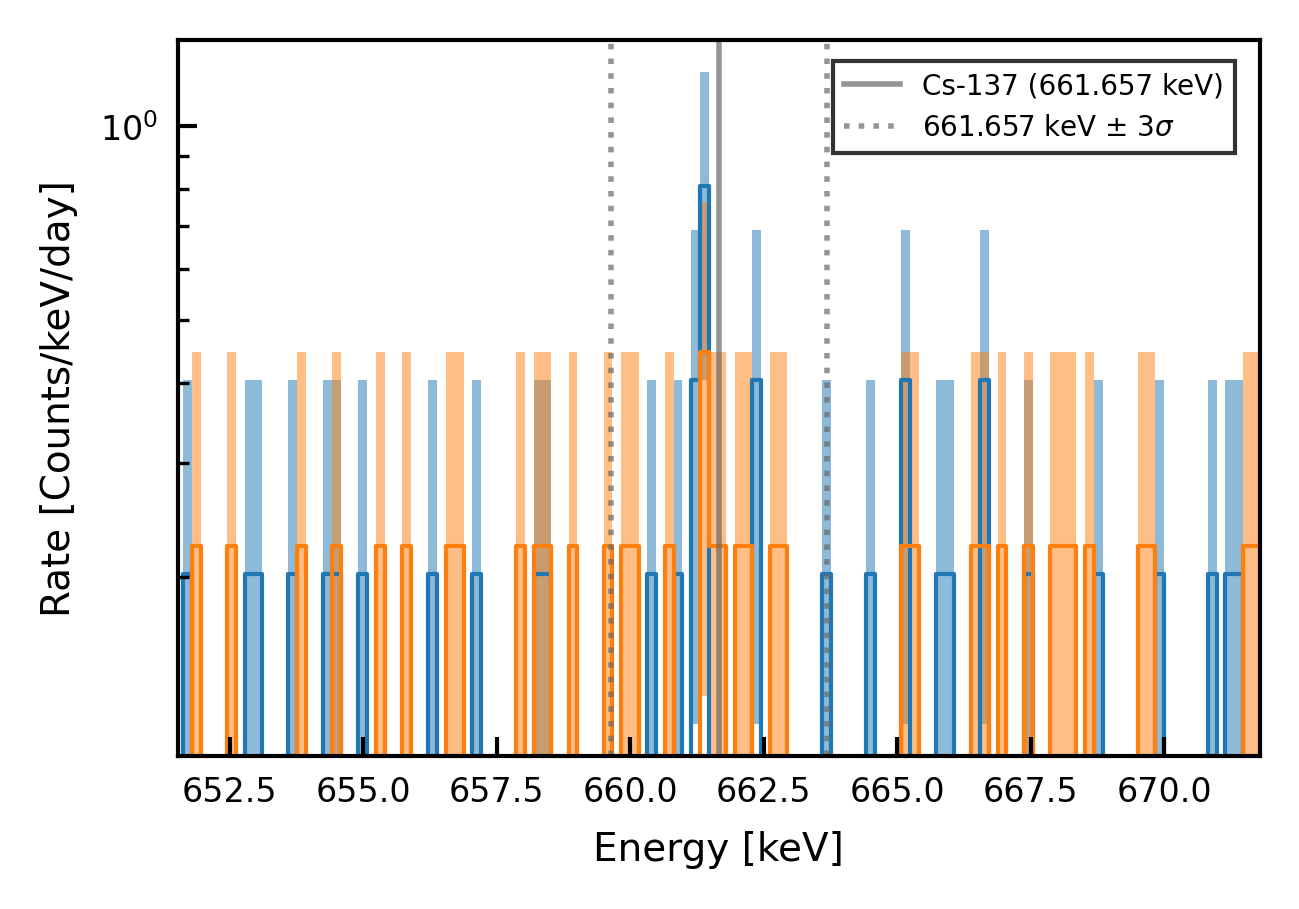

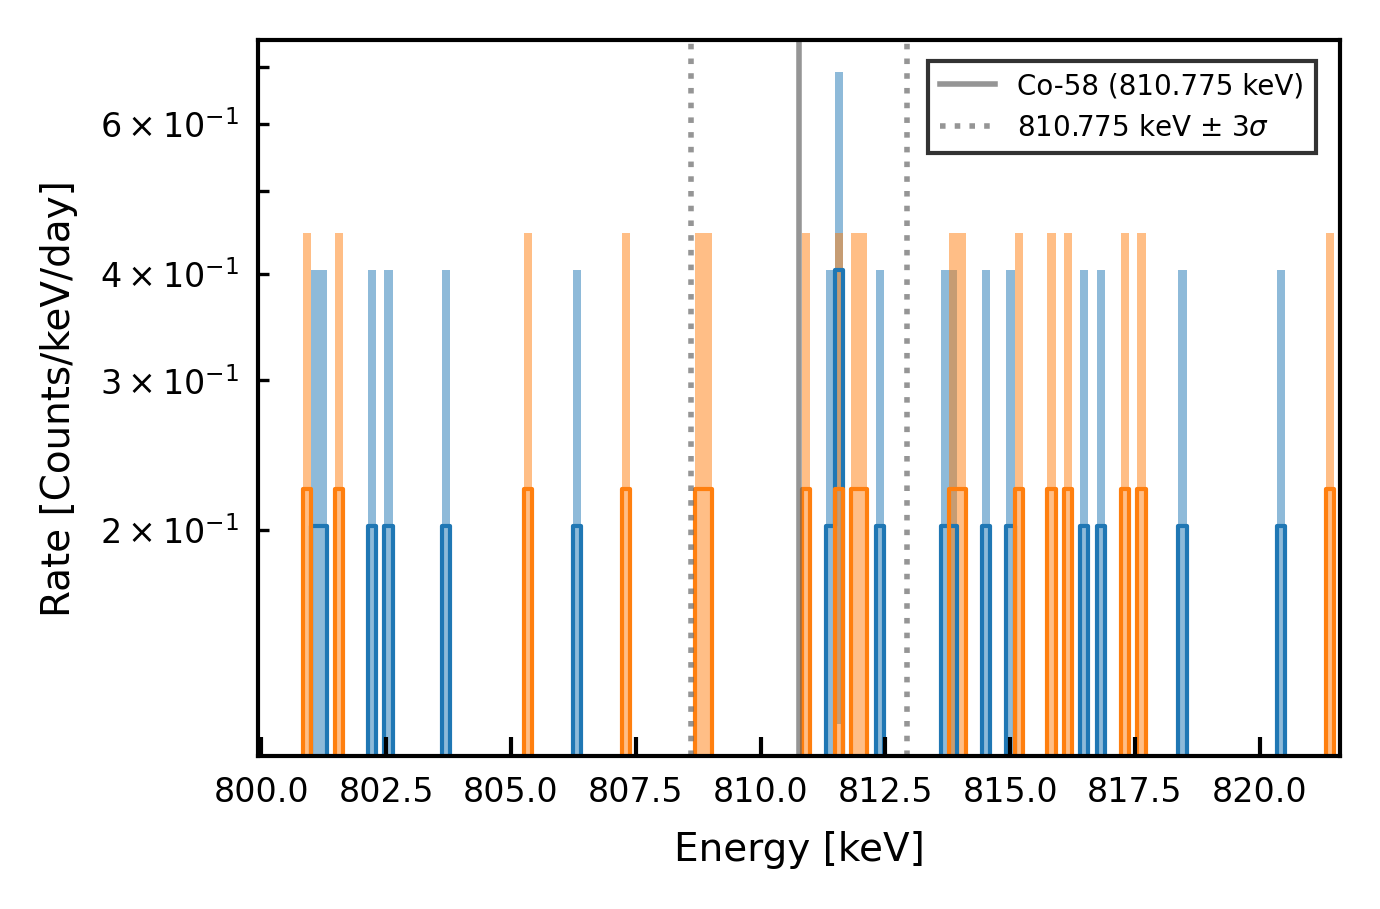

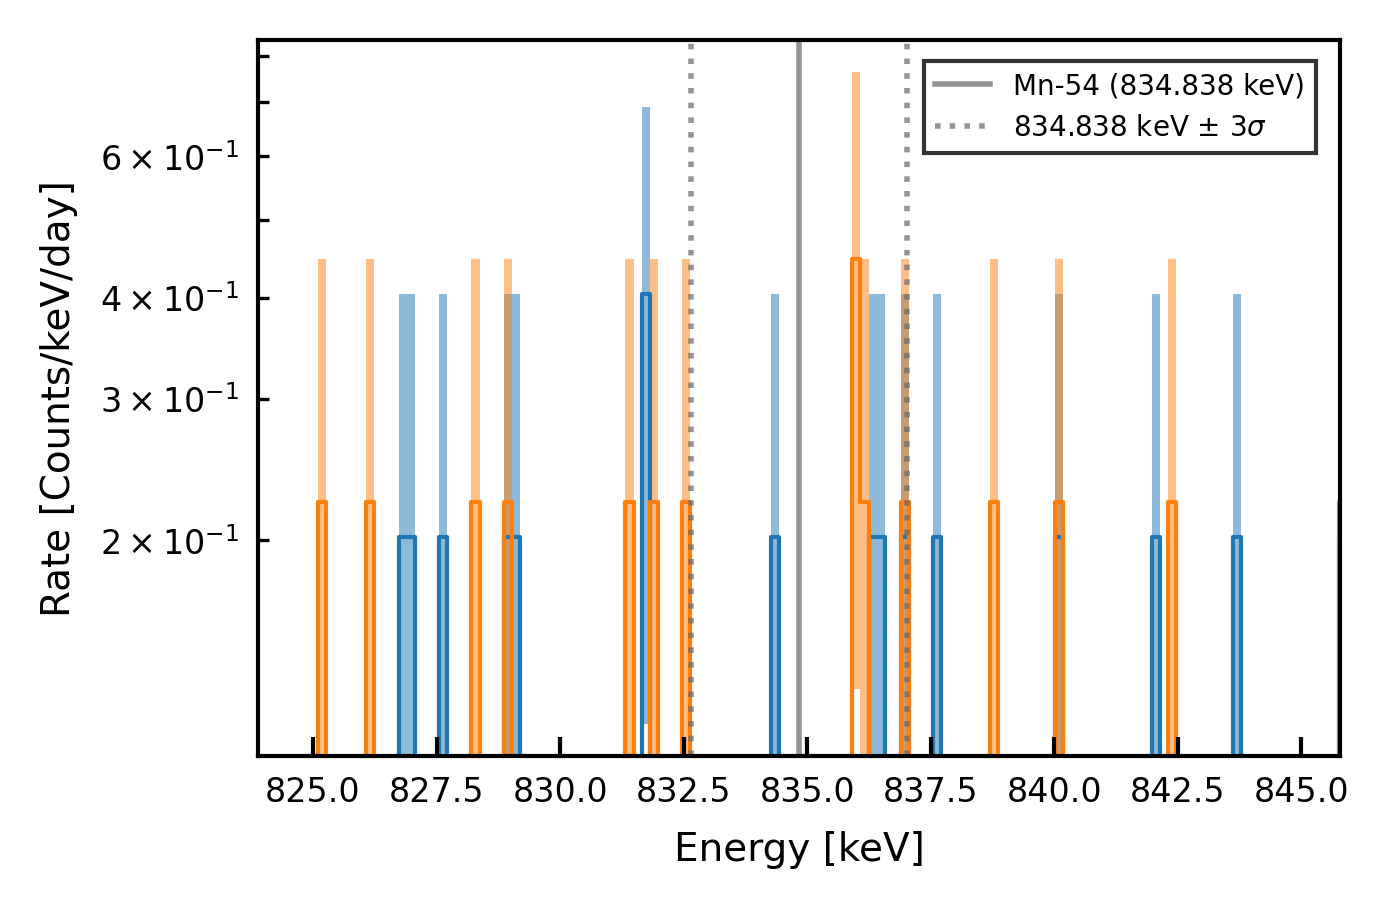

In [21]:
for lbl, en in np.array([df_lines.isotope, df_lines.energy]).T:
    df_sample_rebin = rebin_df(df_in = df_sample, size = 1)
    df_background_rebin = rebin_df(df_in = df_background, size = 1)

    df_sample_rebin = df_sample_rebin[(df_sample_rebin.energy > (en - 20* resolFunc(en))) & (df_sample_rebin.energy <  (en + 20* resolFunc(en)))]
    df_background_rebin = df_background_rebin[(df_background_rebin.energy > (en - 20* resolFunc(en))) & (df_background_rebin.energy <  (en + 20* resolFunc(en)))]

    
    f = plt.figure(figsize=matplotlib.rcParams['figure.figsize'], dpi=400)
    ax = f.add_subplot(111)

    plt.step(df_background_rebin.energy, df_background_rebin.rate, 
             where='mid', linewidth = 0.75, color = 'C0')
    plt.fill_between(df_background_rebin.energy, df_background_rebin.rate - df_background_rebin.rate_err, 
                     df_background_rebin.rate + df_background_rebin.rate_err, 
                     step="mid", color = 'C0', alpha=0.5, linewidth = 0)
    plt.step(df_sample_rebin.energy, df_sample_rebin.rate, 
             where='mid', linewidth = 0.75, color = 'C1')
    plt.fill_between(df_sample_rebin.energy, df_sample_rebin.rate - df_sample_rebin.rate_err, 
                     df_sample_rebin.rate + df_sample_rebin.rate_err, 
                     step="mid", color = 'C1', alpha=0.5, linewidth = 0)

    ####################

    en = en
    isotope = lbl
    plt.axvline(en, color = 'dimgray', linestyle = '-', linewidth = 1, alpha = 0.7, label = isotope+' ('+str(en)+' keV)')
    plt.axvline(en + 3* resolFunc(en), color = 'dimgray', linestyle = 'dotted', linewidth = 1, alpha = 0.7, label = str(en)+' keV $\pm$ $3\sigma$')
    plt.axvline(en - 3* resolFunc(en), color = 'dimgray', linestyle = 'dotted', linewidth = 1, alpha = 0.7)


    ####################

    #ax.xaxis.set_major_locator(MultipleLocator(500))
    #ax.xaxis.set_minor_locator(MultipleLocator(100))

    plt.yscale('log')
    #plt.ylim(2e-1, 1e3)
    plt.xlabel('Energy [keV]')
    plt.ylabel('Rate [Counts/keV/day]')

    plt.xlim(en - 15* resolFunc(en), en + 15* resolFunc(en))

    legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
    legend.get_frame().set_linewidth(0.75)

    #plt.savefig('plots/spectrum_'+save_name+'_'+isotope+'_'+str(int(en))+'_stretch.png', transparent=True, bbox_inches='tight')
    #plt.savefig('plots/spectrum_'+save_name+'_'+isotope+'_'+str(int(en))+'_stretch.pdf', transparent=True, bbox_inches='tight')

    plt.show()